In [49]:
import numpy as np 

## to specify the dataset

In [50]:
Y_0 = np.load('dataset_2/y_T0.npy')
Y_1 = np.load('dataset_2/y_T1.npy')
Y_2 = np.load('dataset_2/y_T2.npy')
Y = np.concatenate((Y_0, Y_1, Y_2))

In [51]:
X_0 = np.load('dataset_2/X_T0.npy')
X_1 = np.load('dataset_2/X_T1.npy')
X_2 = np.load('dataset_2/X_T2.npy')

X = np.concatenate((X_0, X_1, X_2))

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.2, random_state=42)

In [53]:
# 打印训练集和测试集的0,1占比
print("训练集中 0 的占比：", np.mean(Y_train == 0))
print("训练集中 1 的占比：", np.mean(Y_train == 1))
print("训练集中 2 的占比：", np.mean(Y_train == 2))

print("测试集中 0 的占比：", np.mean(Y_test == 0))
print("测试集中 1 的占比：", np.mean(Y_test == 1))
print("训练集中 2 的占比：", np.mean(Y_test == 2))


训练集中 0 的占比： 0.30434782608695654
训练集中 1 的占比： 0.43478260869565216
训练集中 2 的占比： 0.2608695652173913
测试集中 0 的占比： 0.3333333333333333
测试集中 1 的占比： 0.4166666666666667
训练集中 2 的占比： 0.25


In [54]:
# normalization
def normalize(X, vec_min=None, vec_max=None):
    # with maxmin normalization
    if not vec_min:
        vec_min = np.expand_dims(np.min(X, axis=1), axis=-1)
    if not vec_max:
        vec_max = np.expand_dims(np.max(X, axis=1), axis=-1)
    normalized_data = (X - vec_min) / (vec_max - vec_min)
    return normalized_data, vec_min, vec_max

In [55]:
# standardization
def standardize(X, vec_mean=None, vec_std=None):
    if not vec_mean:
        vec_mean = np.mean(X, axis=0)
    if not vec_std:
        vec_std = np.std(X, axis=0)
    standardized_data = (X - vec_mean) / (vec_std)
    return standardized_data, vec_mean, vec_std

In [56]:
from scipy.signal import savgol_filter
def denoise(row, window_size=31, poly_order=4):
    return savgol_filter(row, window_size, poly_order)

In [57]:
X_denoised = np.apply_along_axis(denoise, axis=3, arr=X)
X_train_denoised = np.apply_along_axis(denoise, axis=3, arr=X_train)
X_test_denoised = np.apply_along_axis(denoise, axis=3, arr=X_test)

In [58]:
# with maxmin normalization
normed_X_train, vec_min, vec_max = normalize(X_train_denoised.reshape(-1, 1701))
normed_X_test, _, _ = normalize(X_test_denoised.reshape(-1, 1701))
normed_X_train = normed_X_train.reshape((-1, 3, 300, 1701))
normed_X_test = normed_X_test.reshape((-1, 3, 300, 1701))

In [59]:
meaned_X_train = np.mean(normed_X_train, axis=2)
meaned_X_test = np.mean(normed_X_test, axis=2)

## Phase1 average

In [60]:
def average_multi_spectra(X, Y, num_mean):
    num_sample, num_wave, num_spectrum, num_feature = X.shape 
    tmp = X.reshape(num_sample, num_wave, -1, num_mean, num_feature)
    print(tmp.shape)
    X_shaped = np.mean(tmp, axis=3).reshape(num_sample, num_wave, int(num_spectrum / num_mean), num_feature)
    print(X_shaped.shape)
    Y_shaped = np.repeat(Y, num_spectrum / num_mean)
    print(Y_shaped.shape)
    return X_shaped, Y_shaped

In [61]:
def moving_average_multi_spectra(X, Y, num_mean):
    num_sample, num_wave, num_spectrum, num_feature = X.shape 
    num_spectrum_mean = num_spectrum - num_mean + 1
    result = np.zeros((num_sample, num_wave, num_spectrum_mean, num_feature))
    
    for i in range(num_spectrum_mean):
        result[:, :, i, :] = np.mean(X[:, :, i : i + num_mean, :], axis=2)
    
    return result, np.repeat(Y, num_spectrum_mean)

## process train data set in multi spectra average

In [62]:
normed_X_train_T1, Y_train_T1 = average_multi_spectra(normed_X_train[Y_train == 0], Y_train[Y_train == 0], 20)
normed_X_train_T2, Y_train_T2 = average_multi_spectra(normed_X_train[Y_train == 1], Y_train[Y_train == 1], 20)
normed_X_train_T3, Y_train_T3 = average_multi_spectra(normed_X_train[Y_train == 2], Y_train[Y_train == 2], 20)

(14, 3, 15, 20, 1701)
(14, 3, 15, 1701)
(210,)
(20, 3, 15, 20, 1701)
(20, 3, 15, 1701)
(300,)
(12, 3, 15, 20, 1701)
(12, 3, 15, 1701)
(180,)


In [63]:
normed_X_test_T1, Y_test_T1 = average_multi_spectra(normed_X_test[Y_test == 0], Y_test[Y_test == 0], 20)
normed_X_test_T2, Y_test_T2 = average_multi_spectra(normed_X_test[Y_test == 1], Y_test[Y_test == 1], 20)
normed_X_test_T3, Y_test_T3 = average_multi_spectra(normed_X_test[Y_test == 2], Y_test[Y_test == 2], 20)

(4, 3, 15, 20, 1701)
(4, 3, 15, 1701)
(60,)
(5, 3, 15, 20, 1701)
(5, 3, 15, 1701)
(75,)
(3, 3, 15, 20, 1701)
(3, 3, 15, 1701)
(45,)


In [83]:
Y_train_shaped = np.concatenate((Y_train_T1, Y_train_T2, Y_train_T3), axis=0)
Y_test_shaped = np.concatenate((Y_test_T1, Y_test_T2, Y_test_T3), axis = 0)

In [64]:
def combine_waves(X, indices=None):
    _, num_wave, _, num_feature = X.shape
    x = None
    
    if indices is None:
        indices = range(num_wave)
    
    for i in indices:
        if x is None:
            x = X[:, i, :, :].reshape(-1, num_feature)
        else:
            x = np.concatenate((x, X[:, i, :, :].reshape(-1, num_feature)), axis = 1)
    return x

## Phase2 RandomForest

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel

def train_and_predict(train_set_x, train_set_y, test_set_x, test_set_y, n_estimators=100, max_depth=None, num_features='sqrt', class_weight=None, max_samples=None):
    # permutation_indices = np.random.permutation(len(train_set_x))
    # train_set_x = train_set_x[permutation_indices]
    # train_set_y = train_set_y[permutation_indices]

    # Assuming X is your feature matrix and y is your target variable
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42, max_depth=max_depth, max_features=num_features, class_weight=class_weight, max_samples=max_samples)

    # Train the classifier on the training set
    clf.fit(train_set_x, train_set_y)

    # Make predictions on the train set 
    y_pred_train = clf.predict(train_set_x)
    print(f"Train set accuracy: {accuracy_score(train_set_y, y_pred_train):.2f}")

    # Make predictions on the test set
    y_pred = clf.predict(test_set_x)

    print(y_pred.shape)
    print(y_pred)

    # Evaluate the performance of the classifier
    accuracy = accuracy_score(test_set_y, y_pred)
    classification_report_result = classification_report(test_set_y, y_pred)

    # Print the results
    print(f"Test set accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report_result)
    return clf, y_pred_train, clf.predict_proba(train_set_x) ,y_pred, clf.predict_proba(test_set_x)

## plot 

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

In [67]:
import os

metrics_dir = "./metrics_mean_20"
if not os.path.exists(metrics_dir):
    try:
        os.makedirs(metrics_dir)
        print(f"Directory '{metrics_dir}' created successfully.")
    except OSError as e:
        print(f"Failed to create directory '{metrics_dir}': {e}")
else:
    print(f"Directory '{metrics_dir}' already exists.")

Directory './metrics_mean_20' already exists.


In [105]:
from mlxtend.plotting import plot_confusion_matrix
def draw_confusion_matrix(component, y, y_pred, phase='P1'):
    cm = confusion_matrix(y, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6,6))
    plt.title('Confusion Matrix')
    plt.savefig(f'metrics_mean_20/{component}-{phase}-confusion-matrix.png')

In [106]:
from sklearn.metrics import precision_recall_curve, auc 

def draw_pr_curve(y, y_pred_prob, component, phase='P1'):
    precision, recall, _ = precision_recall_curve(y, y_pred_prob)
    auc_score = auc(recall, precision)
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, label=f'area={auc_score:.3f}')
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig(f'metrics_mean_20/{component}-{phase}-PR.png')

In [107]:
from sklearn.metrics import roc_curve, auc

def draw_roc_curve(y, y_pred_prob, component, phase='P1'):
    fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
    auc_score = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'area={auc_score:.3f}')
    plt.xlabel('False Positive Rate(FPR)')
    plt.ylabel('True Positive Rate(TPR)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig(f'metrics_mean_20/{component}-{phase}-ROC.png')


In [190]:
import pandas as pd
def draw_feature_importance(rf_model, component, phase='P1', waves=None):
    # Get feature importances
    feature_importances = rf_model.feature_importances_

    # Get indices of top 30 features
    top_30_indices = np.argsort(feature_importances)[::-1][:30]

    # Get names of the features
    # Assuming you have a list of feature names, replace feature_names with that list
    # feature_names = X_train.columns.tolist() # If your data is in pandas DataFrame
    if waves is None:
        if component in ['532nm', '638nm', '785nm']:
            waves = [component]
        else:
            waves = ['532nm', '638nm', '785nm']
    base = 1701
    feature_names = [f"{waves[int(i / base)]}-{i % base + 300}nm" for i in range(len(feature_importances))]  # Or you can use generic names if you don't have feature names
    
    df = pd.DataFrame(zip([feature_names[i] for i in top_30_indices], feature_importances[top_30_indices]))
    df.to_csv(f"metrics_mean_20/{component}-{phase}-feature_importance.csv", header=False, index=False)

    # Plot top 30 features
    plt.figure(figsize=(10, 6))
    plt.title("Top 30 Feature Importances")
    plt.bar(range(len(top_30_indices)), feature_importances[top_30_indices], color="skyblue", align="center")
    plt.xticks(range(len(top_30_indices)), [feature_names[i] for i in top_30_indices], rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.tight_layout()
    plt.savefig(f'metrics_mean_20/{component}-{phase}-feature_importances.png')
    plt.show()
    

## SMOTE three classes classification

Train set accuracy: 0.99
(12,)
[1. 0. 1. 0. 0. 2. 2. 1. 1. 1. 0. 0.]
Test set accuracy: 0.83
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      1.00      0.89         4
         1.0       0.80      0.80      0.80         5
         2.0       1.00      0.67      0.80         3

    accuracy                           0.83        12
   macro avg       0.87      0.82      0.83        12
weighted avg       0.85      0.83      0.83        12



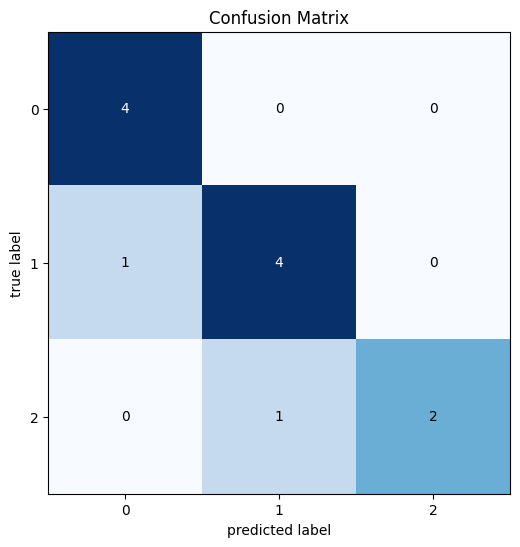

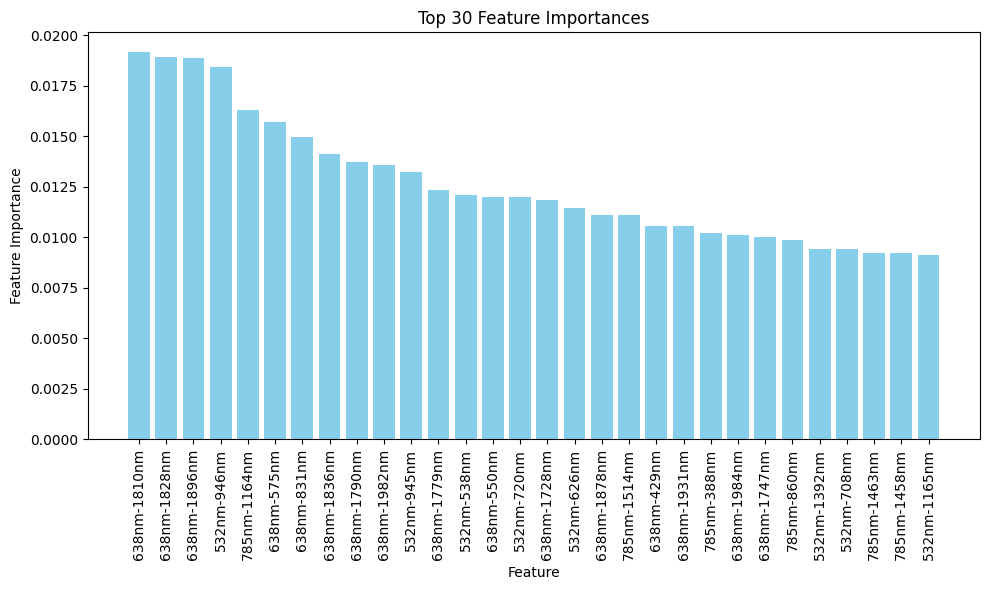

In [195]:
from imblearn.over_sampling import SMOTE
from collections import Counter
target_samples = 60  # Desired number of samples for each class

# Get current class distribution
current_counts = Counter(Y_train)

# Define the sampling strategy
sampling_strategy = {label: target_samples for label in current_counts}

# Apply SMOTE with the custom sampling strategy
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

x = np.concatenate((meaned_X_train[:,0,:] , meaned_X_train[:,1,:], meaned_X_train[:,2,:]), axis=1)
x_test = np.concatenate((meaned_X_test[:,0,:] , meaned_X_test[:,1,:], meaned_X_test[:,2,:]), axis=1)
y = Y_train
y_test = Y_test
x, y = smote.fit_resample(x, y)

# x, x_test = standardization(x, x_test)
# x, x_test = simple_features_selection(x, x_test, y)
clf, y_train, y_train_val, y_pred, y_val = train_and_predict(x, y, x_test, y_test, 20, 4, 'log2', 'balanced', 0.7)
draw_confusion_matrix('SMOTE-RF', y_test,  y_pred, 'all')
# draw_pr_curve(y_test, y_val[:,1], 'total', 'P1')
# draw_roc_curve(y_test, y_val[:,1], 'total', 'P1')
draw_feature_importance(clf, 'SMOTE-RF', 'all')

## SMOTE for one-component

Train set accuracy: 0.99
(12,)
[1. 1. 1. 1. 1. 2. 0. 1. 2. 1. 1. 0.]
Test set accuracy: 0.67
Classification Report:
               precision    recall  f1-score   support

         0.0       0.50      0.25      0.33         4
         1.0       0.62      1.00      0.77         5
         2.0       1.00      0.67      0.80         3

    accuracy                           0.67        12
   macro avg       0.71      0.64      0.63        12
weighted avg       0.68      0.67      0.63        12



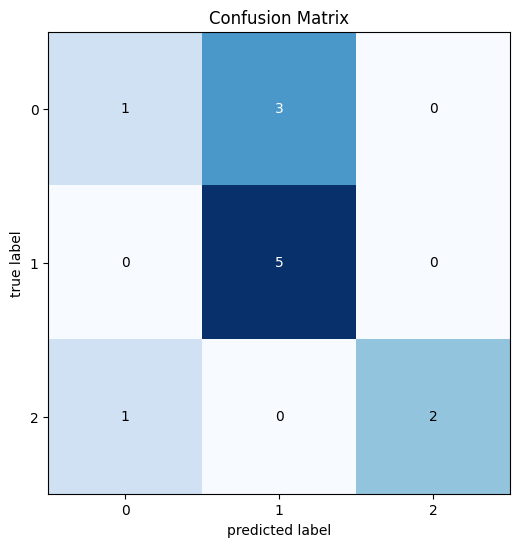

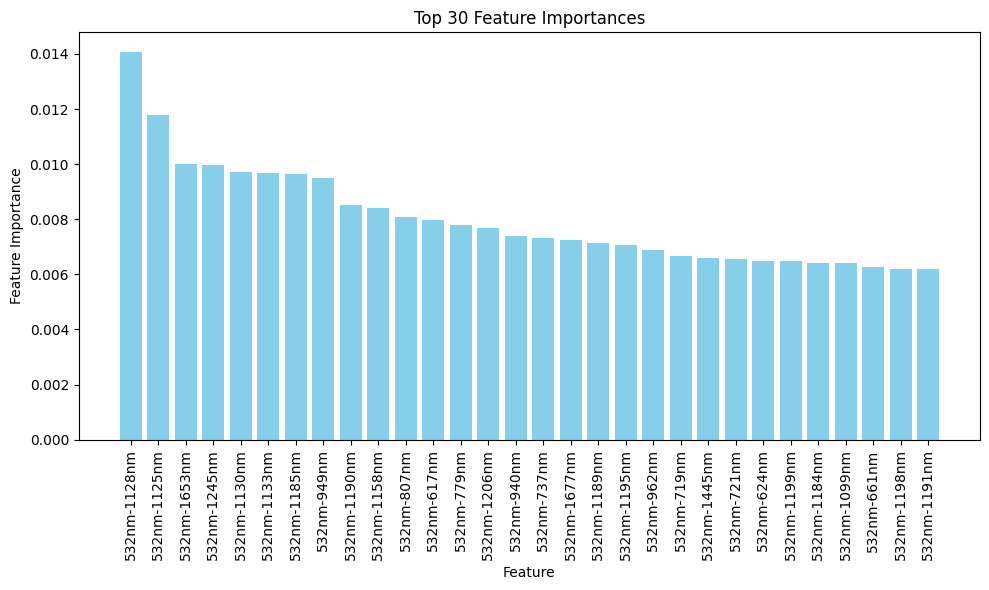

Train set accuracy: 0.97
(12,)
[2. 0. 1. 0. 0. 1. 2. 1. 1. 1. 1. 0.]
Test set accuracy: 0.58
Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.75      0.75         4
         1.0       0.50      0.60      0.55         5
         2.0       0.50      0.33      0.40         3

    accuracy                           0.58        12
   macro avg       0.58      0.56      0.57        12
weighted avg       0.58      0.58      0.58        12



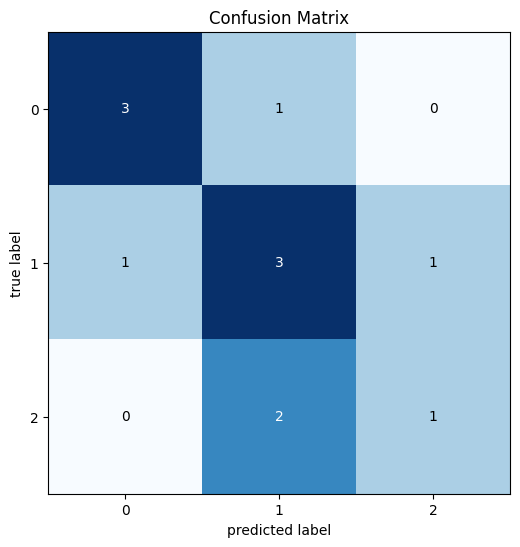

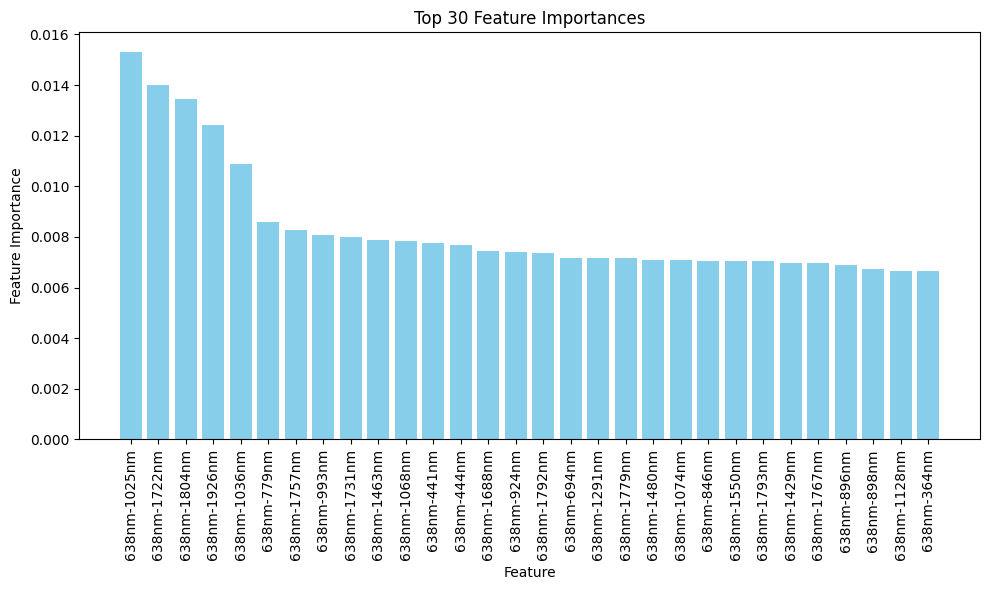

Train set accuracy: 0.97
(12,)
[1. 2. 2. 2. 0. 1. 0. 1. 1. 1. 1. 0.]
Test set accuracy: 0.33
Classification Report:
               precision    recall  f1-score   support

         0.0       0.33      0.25      0.29         4
         1.0       0.50      0.60      0.55         5
         2.0       0.00      0.00      0.00         3

    accuracy                           0.33        12
   macro avg       0.28      0.28      0.28        12
weighted avg       0.32      0.33      0.32        12



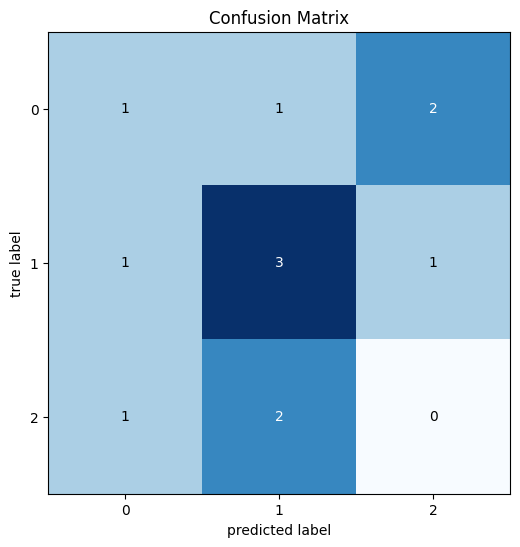

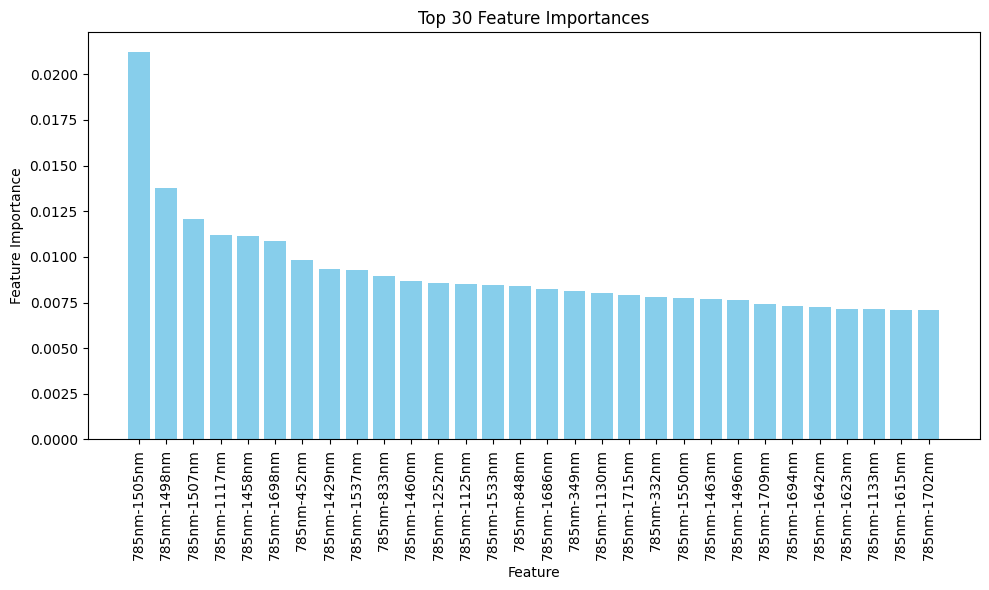

In [191]:
components = ['532nm', '638nm', '785nm']

for i, component in enumerate(components):
    x = meaned_X_train[:,i,:]
    x_test = meaned_X_test[:,i,:]
    y = Y_train
    y_test = Y_test
    x, y = smote.fit_resample(x, y)

    clf, _, _, y_pred, y_val = train_and_predict(x, y, x_test, y_test, 40, 4, 'log2', 'balanced', 0.7)
    draw_confusion_matrix('SMOTE-RF', y_test,  y_pred,  component)
    draw_feature_importance(clf, 'SMOTE-RF', component, [component])

Train set accuracy: 0.99
(12,)
[1. 0. 1. 0. 0. 2. 2. 1. 1. 1. 1. 0.]
Test set accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.75      0.75         4
         1.0       0.67      0.80      0.73         5
         2.0       1.00      0.67      0.80         3

    accuracy                           0.75        12
   macro avg       0.81      0.74      0.76        12
weighted avg       0.78      0.75      0.75        12



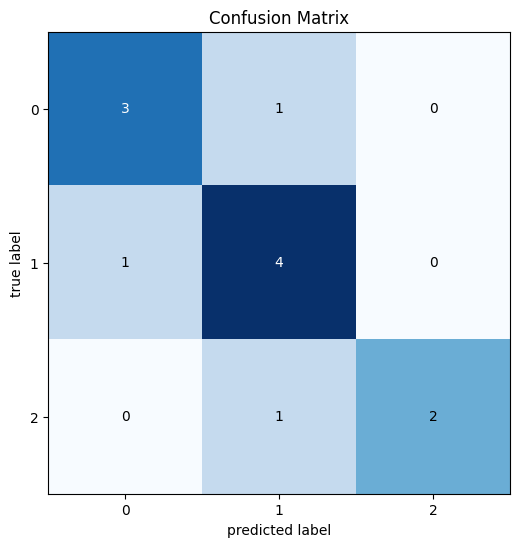

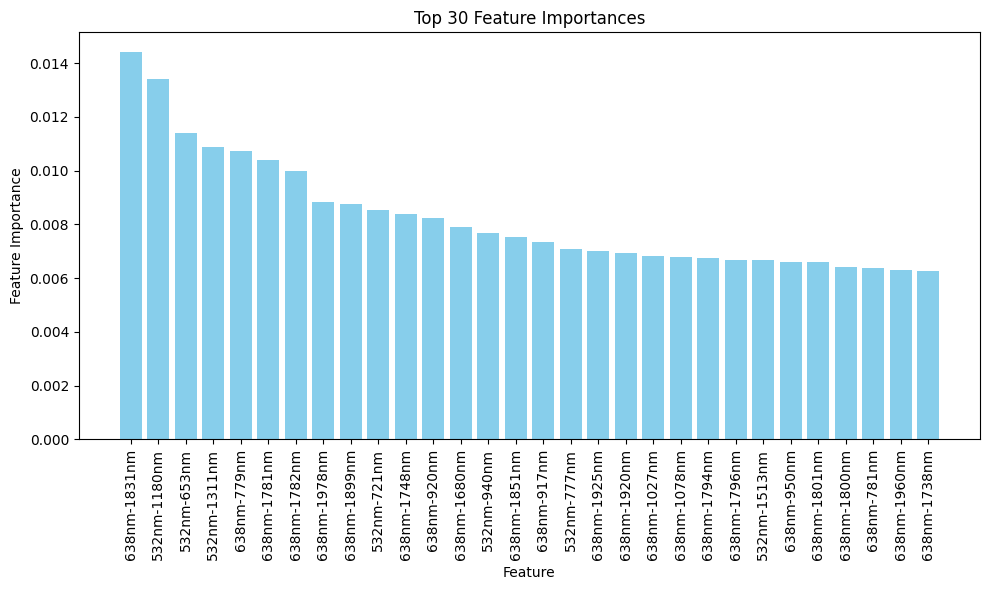

In [192]:
x = np.concatenate((meaned_X_train[:,0,:] , meaned_X_train[:,1,:]), axis=1)
x_test = np.concatenate((meaned_X_test[:,0,:] , meaned_X_test[:,1,:]), axis=1)
y = Y_train
y_test = Y_test
x, y = smote.fit_resample(x, y)

# x, x_test = standardization(x, x_test)
# x, x_test = simple_features_selection(x, x_test, y)
clf, y_train, y_train_val, y_pred, y_val = train_and_predict(x, y, x_test, y_test, 40, 4, 'log2', 'balanced', 0.7)
draw_confusion_matrix('SMOTE-RF', y_test,  y_pred, '532nm+638nm')
# draw_pr_curve(y_test, y_val[:,1], 'total', 'P1')
# draw_roc_curve(y_test, y_val[:,1], 'total', 'P1')
draw_feature_importance(clf, 'SMOTE-RF', '532nm+638nm', ['532nm', '638nm'])

Train set accuracy: 0.95
(12,)
[1. 0. 1. 1. 0. 2. 2. 1. 1. 1. 1. 0.]
Test set accuracy: 0.67
Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.50      0.57         4
         1.0       0.57      0.80      0.67         5
         2.0       1.00      0.67      0.80         3

    accuracy                           0.67        12
   macro avg       0.75      0.66      0.68        12
weighted avg       0.71      0.67      0.67        12



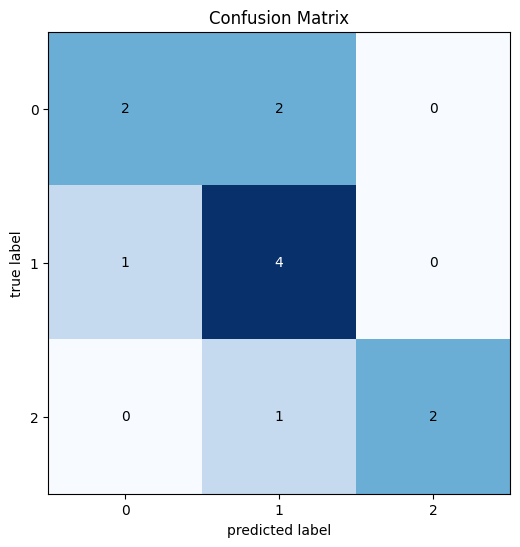

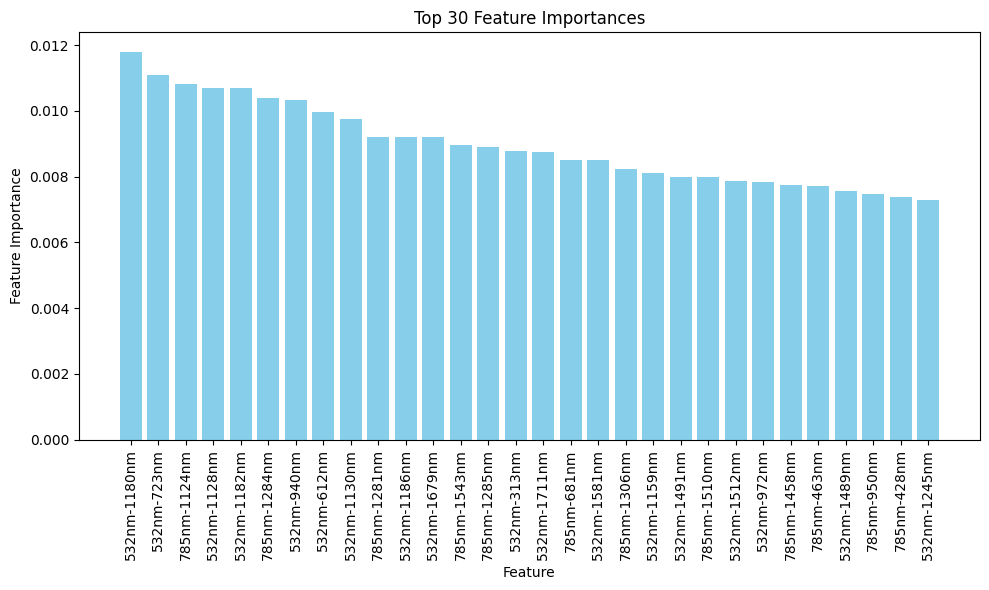

In [193]:
x = np.concatenate((meaned_X_train[:,0,:] , meaned_X_train[:,2,:]), axis=1)
x_test = np.concatenate((meaned_X_test[:,0,:] , meaned_X_test[:,2,:]), axis=1)
y = Y_train
y_test = Y_test
x, y = smote.fit_resample(x, y)


clf, y_train, y_train_val, y_pred, y_val = train_and_predict(x, y, x_test, y_test, 30, 4, 'log2', 'balanced', 0.7)
draw_confusion_matrix('SMOTE-RF', y_test,  y_pred, '532nm+785nm')
draw_feature_importance(clf, 'SMOTE-RF', '532nm+785nm', ['532nm', '785nm'])

Train set accuracy: 0.99
(12,)
[1. 0. 1. 0. 0. 1. 2. 1. 1. 1. 1. 0.]
Test set accuracy: 0.67
Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.75      0.75         4
         1.0       0.57      0.80      0.67         5
         2.0       1.00      0.33      0.50         3

    accuracy                           0.67        12
   macro avg       0.77      0.63      0.64        12
weighted avg       0.74      0.67      0.65        12



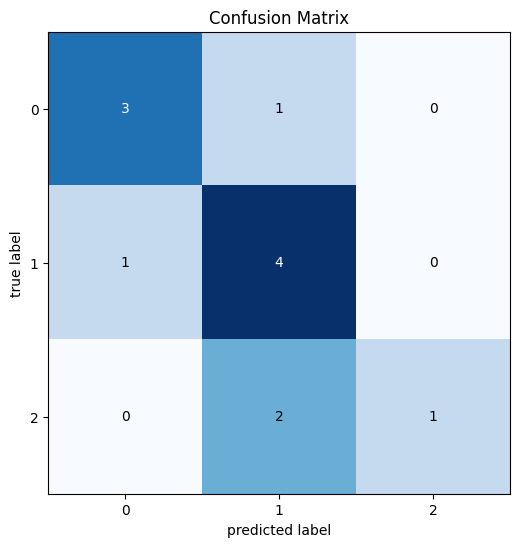

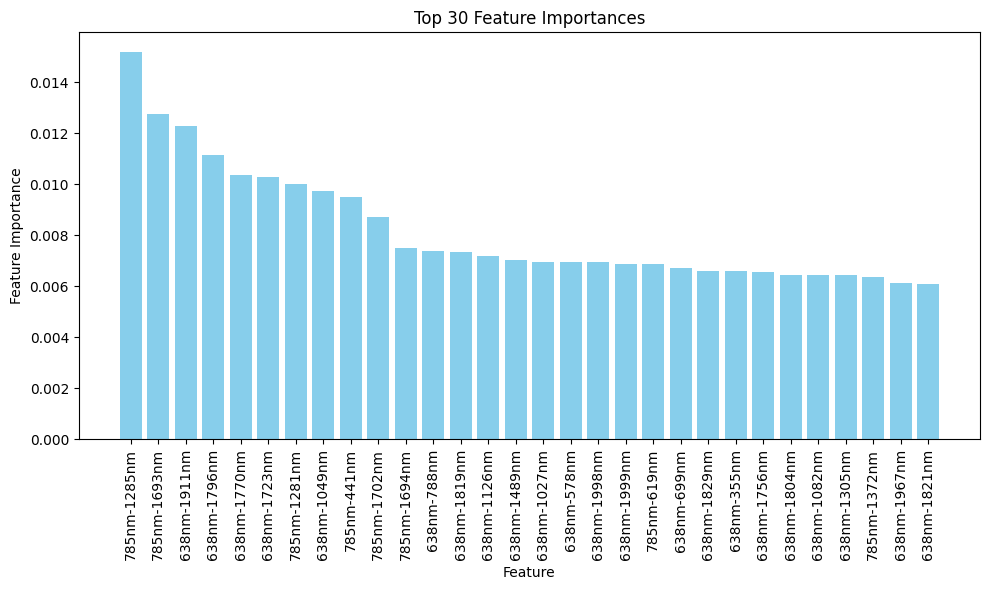

In [194]:
x = np.concatenate((meaned_X_train[:,1,:] , meaned_X_train[:,2,:]), axis=1)
x_test = np.concatenate((meaned_X_test[:,1,:] , meaned_X_test[:,2,:]), axis=1)
y = Y_train
y_test = Y_test
x, y = smote.fit_resample(x, y)

# x, x_test = standardization(x, x_test)
# x, x_test = simple_features_selection(x, x_test, y)
clf, y_train, y_train_val, y_pred, y_val = train_and_predict(x, y, x_test, y_test, 40, 4, 'log2', 'balanced', 0.7)
draw_confusion_matrix('SMOTE-RF', y_test,  y_pred, '638nm+785nm')
# draw_pr_curve(y_test, y_val[:,1], 'total', 'P1')
# draw_roc_curve(y_test, y_val[:,1], 'total', 'P1')
draw_feature_importance(clf, 'SMOTE-RF', '638nm+785nm', ['638nm', '785nm'])

Train set accuracy: 0.99
(12,)
[1. 0. 1. 0. 0. 2. 2. 1. 1. 1. 0. 0.]
Test set accuracy: 0.83
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      1.00      0.89         4
         1.0       0.80      0.80      0.80         5
         2.0       1.00      0.67      0.80         3

    accuracy                           0.83        12
   macro avg       0.87      0.82      0.83        12
weighted avg       0.85      0.83      0.83        12



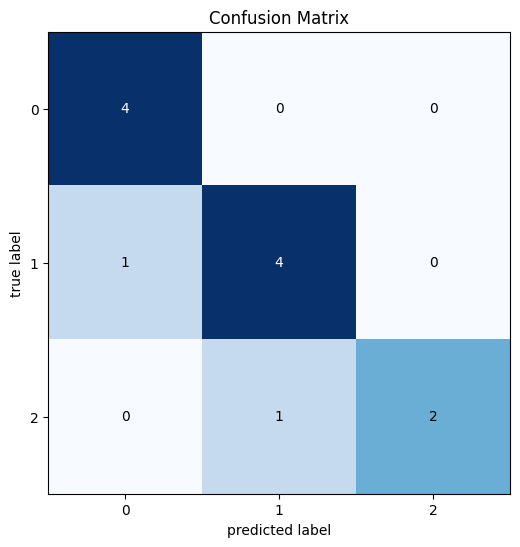

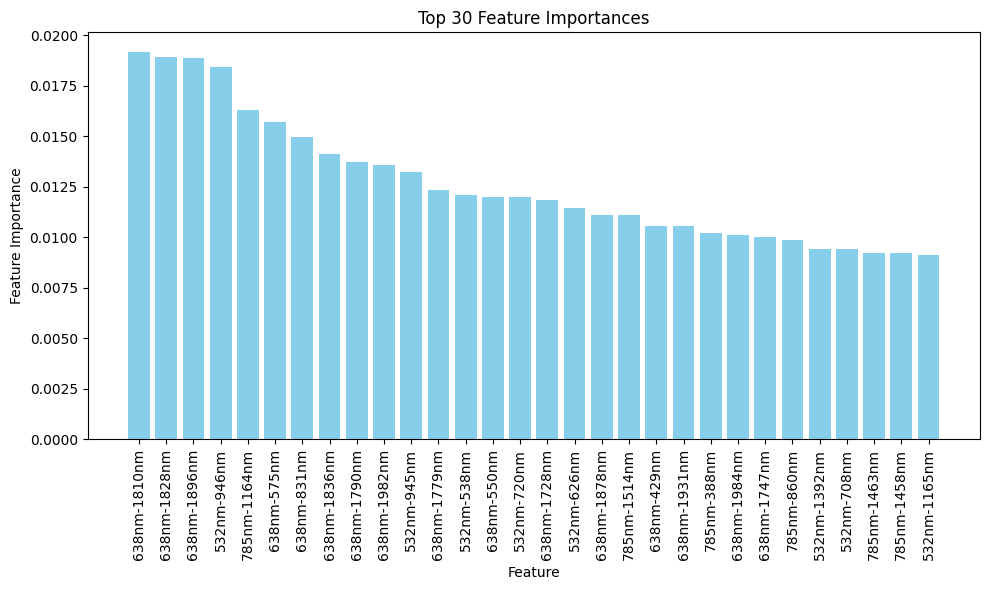

In [78]:
x = np.concatenate((meaned_X_train[:,0,:] , meaned_X_train[:,1,:], meaned_X_train[:,2,:]), axis=1)
x_test = np.concatenate((meaned_X_test[:,0,:] , meaned_X_test[:,1,:], meaned_X_test[:,2,:]), axis=1)
y = Y_train
y_test = Y_test
x, y = smote.fit_resample(x, y)

# x, x_test = standardization(x, x_test)
# x, x_test = simple_features_selection(x, x_test, y)
clf, y_train, y_train_val, y_pred, y_val = train_and_predict(x, y, x_test, y_test, 20, 4, 'log2', 'balanced', 0.7)
draw_confusion_matrix('total', y_test,  y_pred, 'P1')
# draw_pr_curve(y_test, y_val[:,1], 'total', 'P1')
# draw_roc_curve(y_test, y_val[:,1], 'total', 'P1')
draw_feature_importance(clf, 'total', 'P1')

Train set accuracy: 1.00
(12,)
[1. 0. 1. 0. 0. 2. 2. 1. 1. 1. 0. 0.]
Test set accuracy: 0.83
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      1.00      0.89         4
         1.0       0.80      0.80      0.80         5
         2.0       1.00      0.67      0.80         3

    accuracy                           0.83        12
   macro avg       0.87      0.82      0.83        12
weighted avg       0.85      0.83      0.83        12



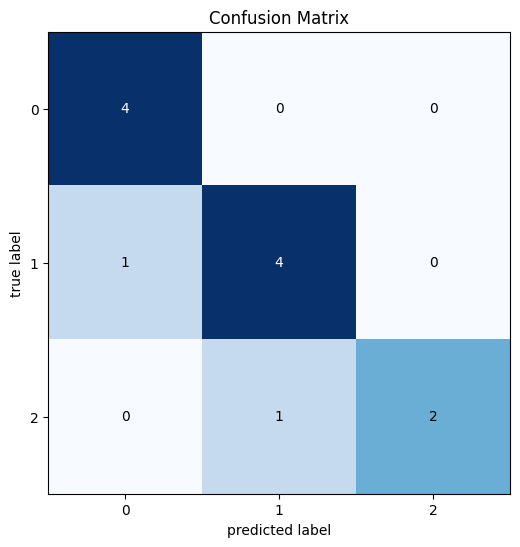

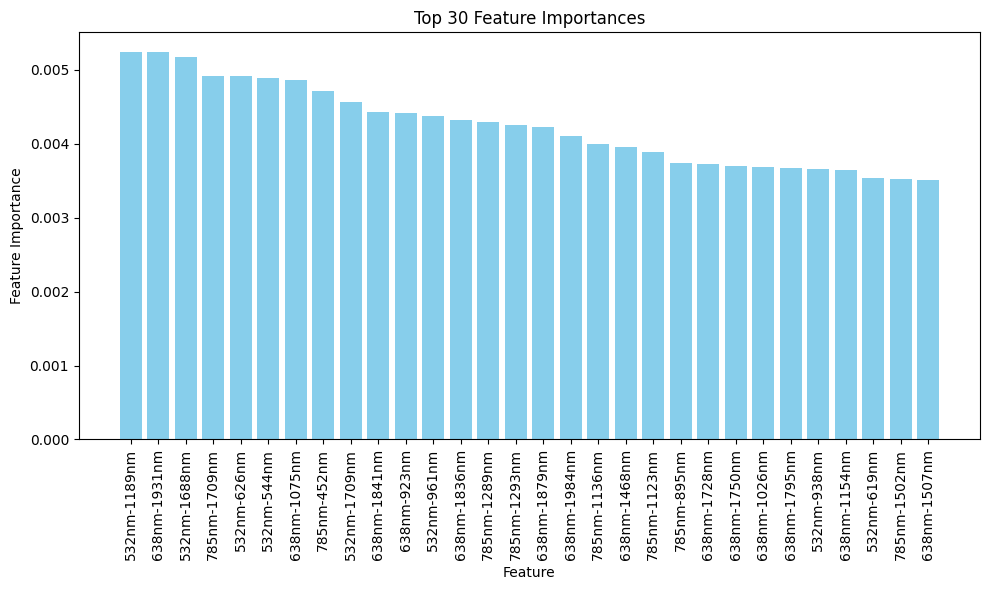

In [79]:
from imblearn.over_sampling import SMOTE

x = np.concatenate((meaned_X_train[:,0,:] , meaned_X_train[:,1,:], meaned_X_train[:,2,:]), axis=1)
x_test = np.concatenate((meaned_X_test[:,0,:] , meaned_X_test[:,1,:], meaned_X_test[:,2,:]), axis=1)
y = Y_train
y_test = Y_test

smote = SMOTE(random_state=42)
x, y = smote.fit_resample(x, y)

# x, x_test = standardization(x, x_test)
# x, x_test = simple_features_selection(x, x_test, y)
clf, y_train, y_train_val, y_pred, y_val = train_and_predict(x, y, x_test, y_test, 100, 5, 'log2', 'balanced', 0.7)
draw_confusion_matrix('total', y_test,  y_pred, 'P1')
# draw_pr_curve(y_test, y_val[:,1], 'total', 'P1')
# draw_roc_curve(y_test, y_val[:,1], 'total', 'P1')
draw_feature_importance(clf, 'total', 'P1')

Train set accuracy: 0.96
(12,)
[1. 1. 1. 1. 1. 2. 0. 1. 1. 1. 1. 2.]
Test set accuracy: 0.50
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.56      1.00      0.71         5
         2.0       0.50      0.33      0.40         3

    accuracy                           0.50        12
   macro avg       0.35      0.44      0.37        12
weighted avg       0.36      0.50      0.40        12

Train set accuracy: 0.98
(12,)
[1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
Test set accuracy: 0.58
Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         4
         1.0       0.50      0.60      0.55         5
         2.0       0.00      0.00      0.00         3

    accuracy                           0.58        12
   macro avg       0.39      0.53      0.45        12
weighted avg       0.43      0.58      0.49        12



c:\Users\Hang Li\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Hang Li\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Hang Li\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Train set accuracy: 0.98
(12,)
[1. 0. 1. 2. 0. 1. 0. 1. 1. 1. 1. 0.]
Test set accuracy: 0.50
Classification Report:
               precision    recall  f1-score   support

         0.0       0.50      0.50      0.50         4
         1.0       0.57      0.80      0.67         5
         2.0       0.00      0.00      0.00         3

    accuracy                           0.50        12
   macro avg       0.36      0.43      0.39        12
weighted avg       0.40      0.50      0.44        12



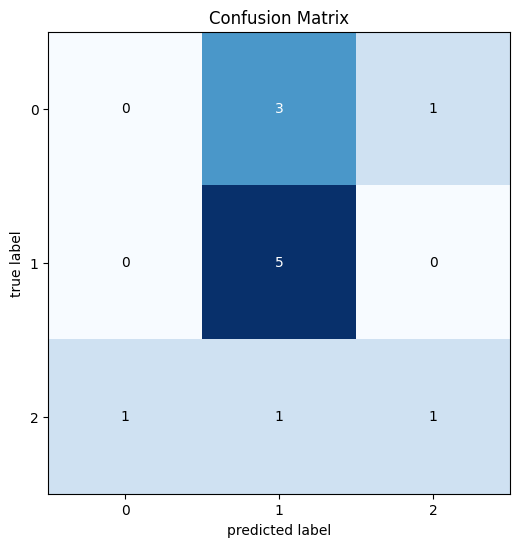

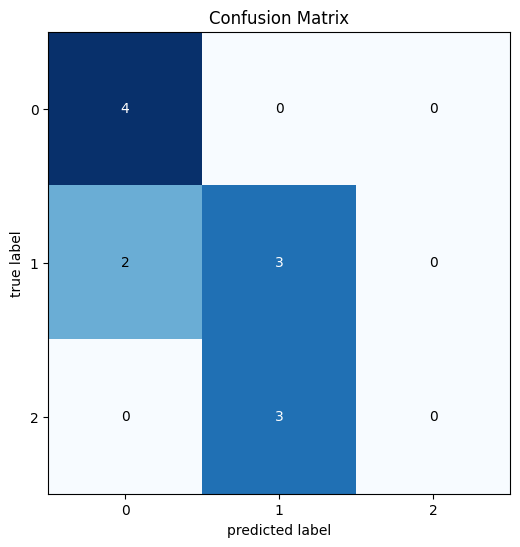

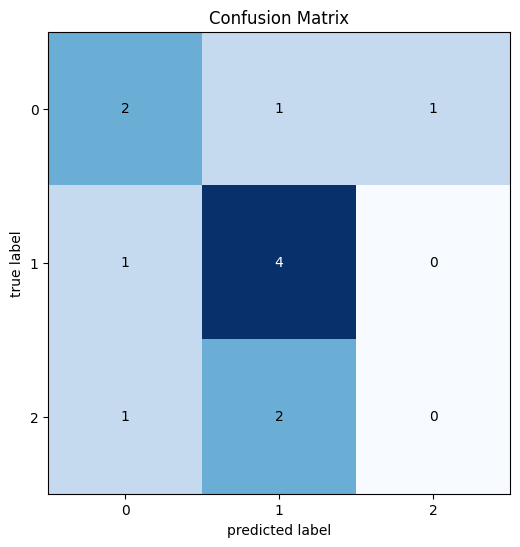

In [80]:
components = ['532nm', '638nm', '785nm']

for i, component in enumerate(components):
    x = meaned_X_train[:,i,:]
    x_test = meaned_X_test[:,i,:]
    y = Y_train
    y_test = Y_test
    clf, _, _, y_pred, y_val = train_and_predict(x, y, x_test, y_test, 300, 3,'log2', 'balanced', 0.7)
    draw_confusion_matrix(component, y_test,  y_pred, 'P1')
    # draw_pr_curve(y_test, y_val[:,1], component, 'P1')
    # draw_roc_curve(y_test, y_val[:,1], component, 'P1')
    # draw_feature_importance(clf, component, 'P1')


## original data

Train set accuracy: 0.80
(3600,)
[2. 2. 2. ... 0. 0. 0.]
Test set accuracy: 0.69
Classification Report:
               precision    recall  f1-score   support

         0.0       0.68      0.77      0.72      1200
         1.0       0.66      0.67      0.66      1500
         2.0       0.79      0.62      0.69       900

    accuracy                           0.69      3600
   macro avg       0.71      0.69      0.69      3600
weighted avg       0.70      0.69      0.69      3600



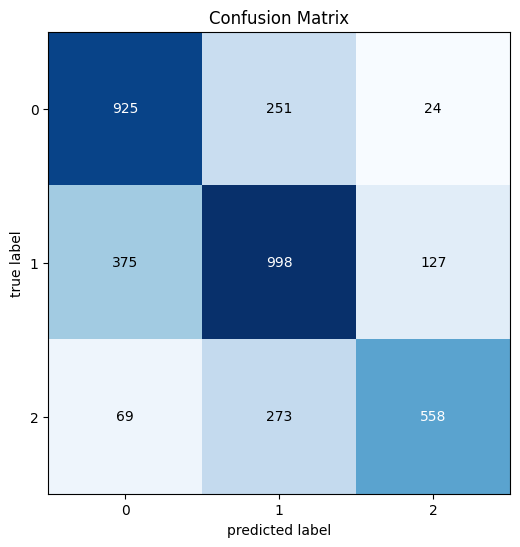

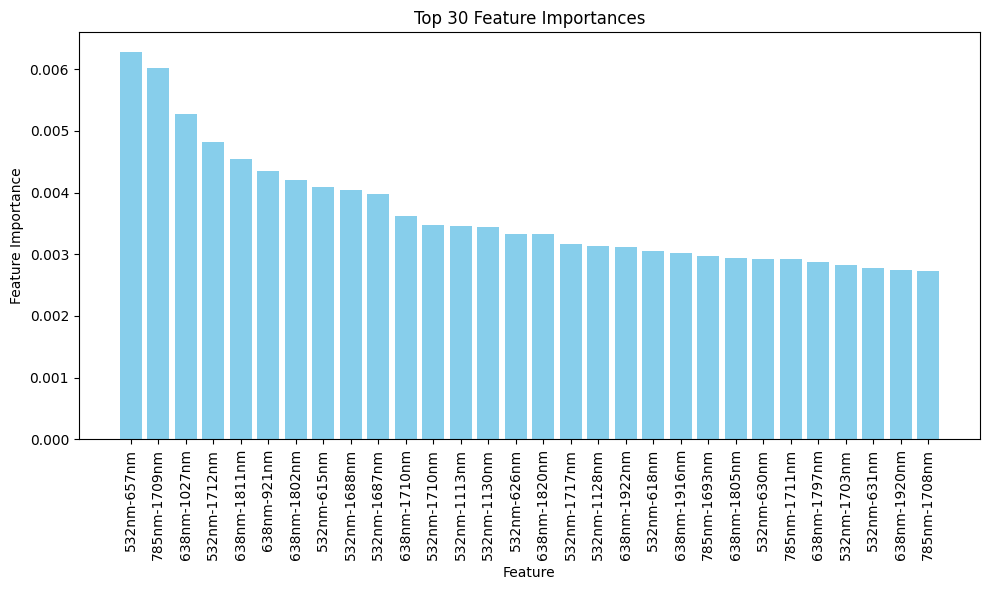

In [81]:
x = combine_waves(normed_X_train)
x_test = combine_waves(normed_X_test)

y = np.repeat(Y_train, 300)
y_test = np.repeat(Y_test, 300)
# x, x_test = standardization(x, x_test)
# x, x_test = simple_features_selection(x, x_test, y)
clf, y_train, y_train_val, y_pred, y_val = train_and_predict(x, y, x_test, y_test, 300, 3, 'log2', 'balanced', 0.8)
draw_confusion_matrix('total', y_test,  y_pred, 'P1')
# draw_pr_curve(y_test, y_val[:,1], 'total', 'P1')
# draw_roc_curve(y_test, y_val[:,1], 'total', 'P1')
draw_feature_importance(clf, 'total', 'P1')

## per20-average

### per20-average three-components

Train set accuracy: 0.96
(180,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 1. 1. 2. 1. 1. 1. 1. 1. 1. 2.]
Test set accuracy: 0.84
Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.95      0.85        60
         1.0       0.84      0.77      0.81        75
         2.0       1.00      0.82      0.90        45

    accuracy                           0.84       180
   macro avg       0.87      0.85      0.85       180
weighted avg       0.86      0.84      0.84  

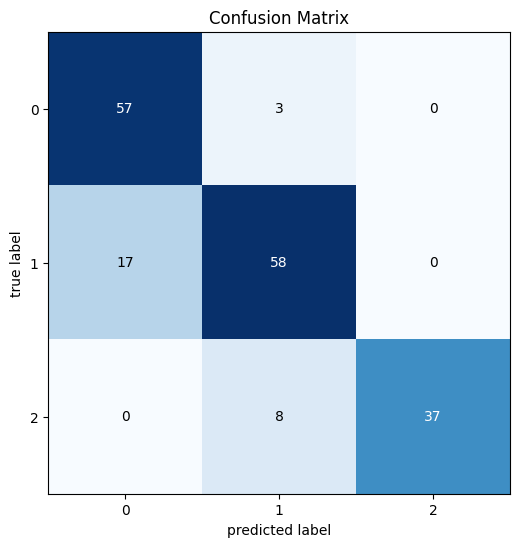

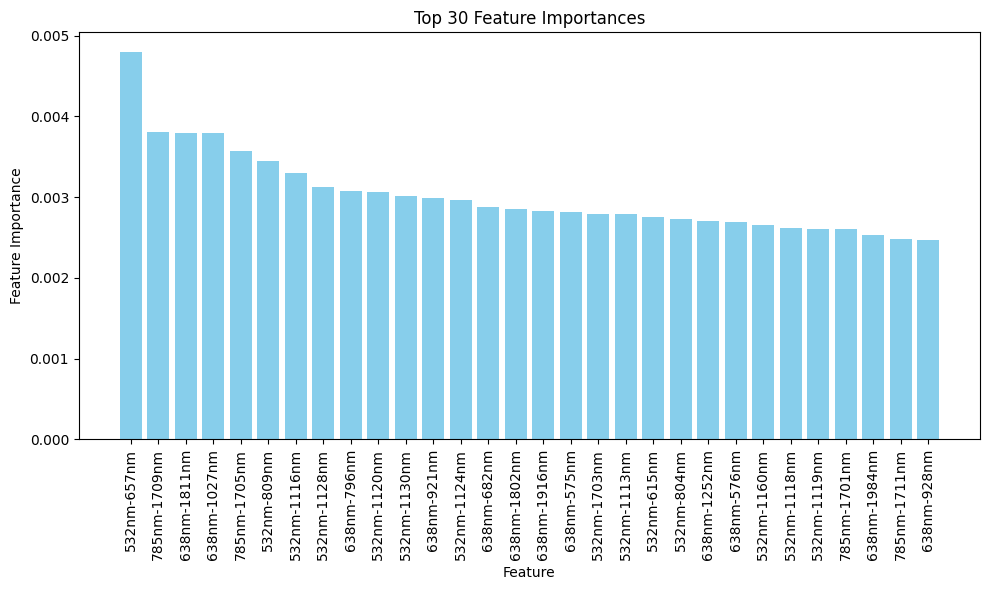

In [110]:
x = np.concatenate((combine_waves(normed_X_train_T1), combine_waves(normed_X_train_T2), combine_waves(normed_X_train_T3)), axis = 0)
x_test = np.concatenate((combine_waves(normed_X_test_T1), combine_waves(normed_X_test_T2), combine_waves(normed_X_test_T3)), axis = 0)
y = Y_train_shaped
y_test = Y_test_shaped
# x, x_test = standardization(x, x_test)
# x, x_test = simple_features_selection(x, x_test, y)
clf, y_train, y_train_val, y_pred, y_val = train_and_predict(x, y, x_test, y_test, 300, 3, 'log2', 'balanced', 0.9)
draw_confusion_matrix('RF', y_test,  y_pred, 'all')
# draw_pr_curve(y_test, y_val[:,1], 'total', 'P1')
# draw_roc_curve(y_test, y_val[:,1], 'total', 'P1')
draw_feature_importance(clf, 'RF', 'all')

### per20-average one-component

Train set accuracy: 0.99
(180,)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.]
Test set accuracy: 0.59
Classification Report:
               precision    recall  f1-score   support

         0.0       0.52      0.25      0.34        60
         1.0       0.55      0.99      0.71        75
         2.0       1.00      0.38      0.55        45

    accuracy                           0.59       180
   macro avg       0.69      0.54      0.53       180
weighted avg       0.65      0.59      0.54  

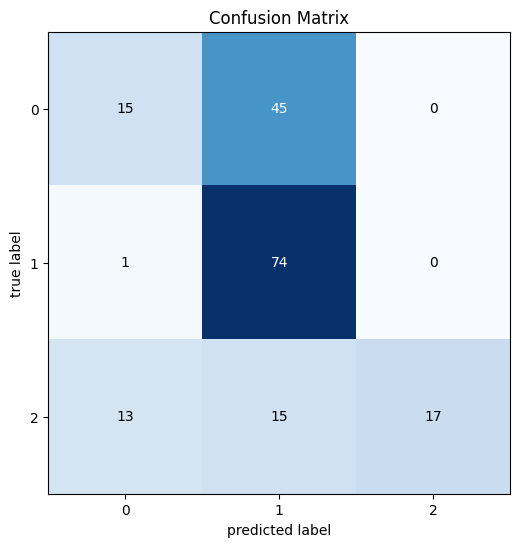

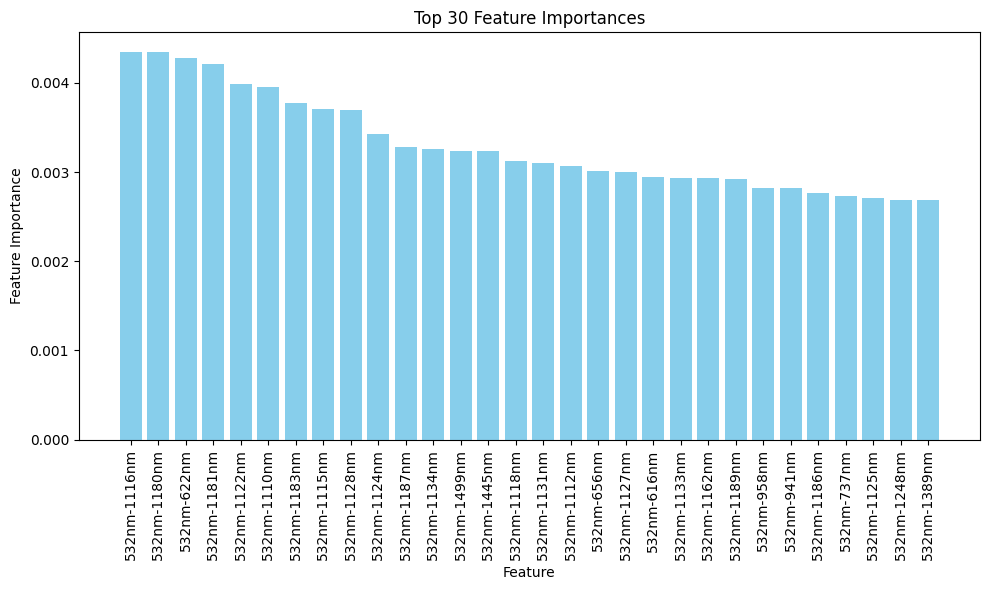

Train set accuracy: 1.00
(180,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 2. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test set accuracy: 0.50
Classification Report:
               precision    recall  f1-score   support

         0.0       0.60      0.82      0.69        60
         1.0       0.42      0.55      0.48        75
         2.0       0.00      0.00      0.00        45

    accuracy                           0.50       180
   macro avg       0.34      0.45      0.39       180
weighted avg       0.38      0.50      0.43  

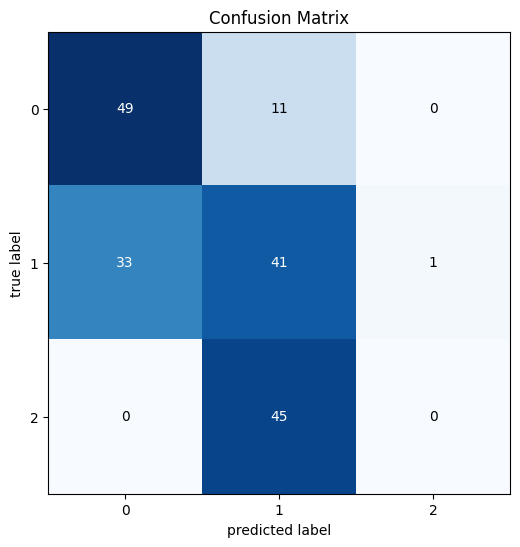

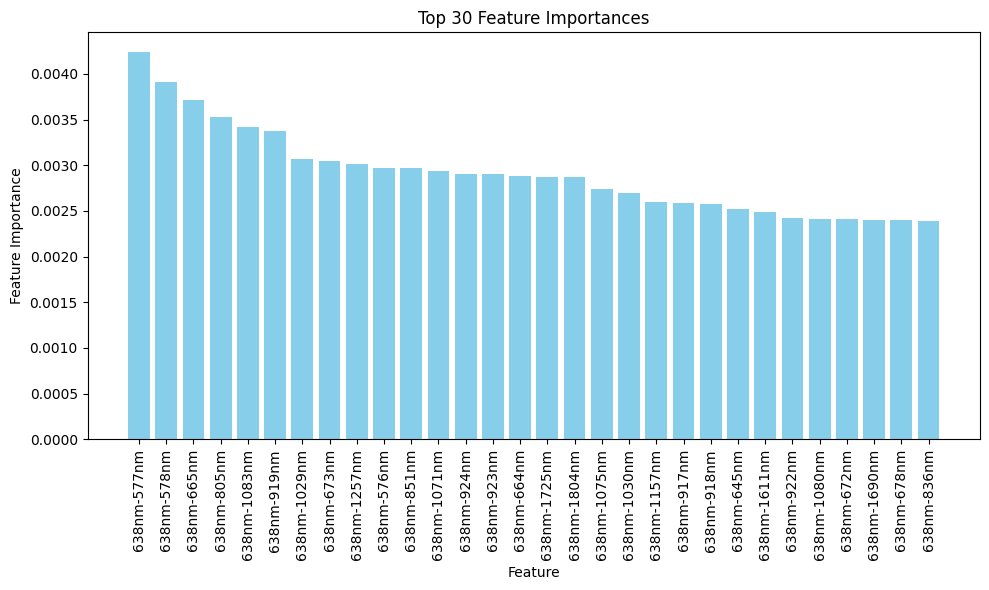

Train set accuracy: 0.98
(180,)
[0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 2. 2.
 0. 2. 0. 1. 0. 2. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 2. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test set accuracy: 0.39
Classification Report:
               precision    recall  f1-score   support

         0.0       0.52      0.52      0.52        60
         1.0       0.46      0.49      0.47        75
         2.0       0.05      0.04      0.05        45

    accuracy                           0.39       180
   macro avg       0.34      0.35      0.35       180
weighted avg       0.38      0.39      0.38  

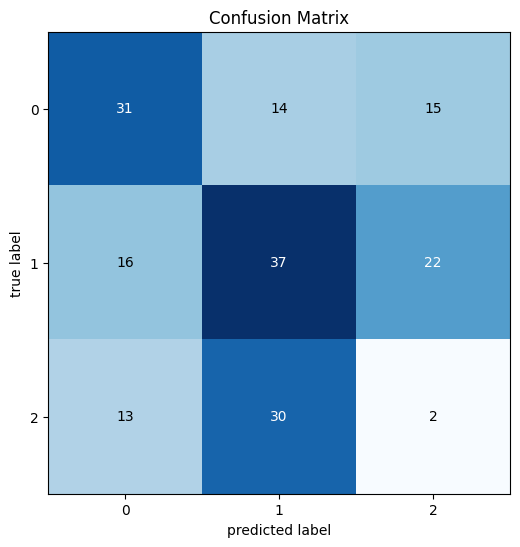

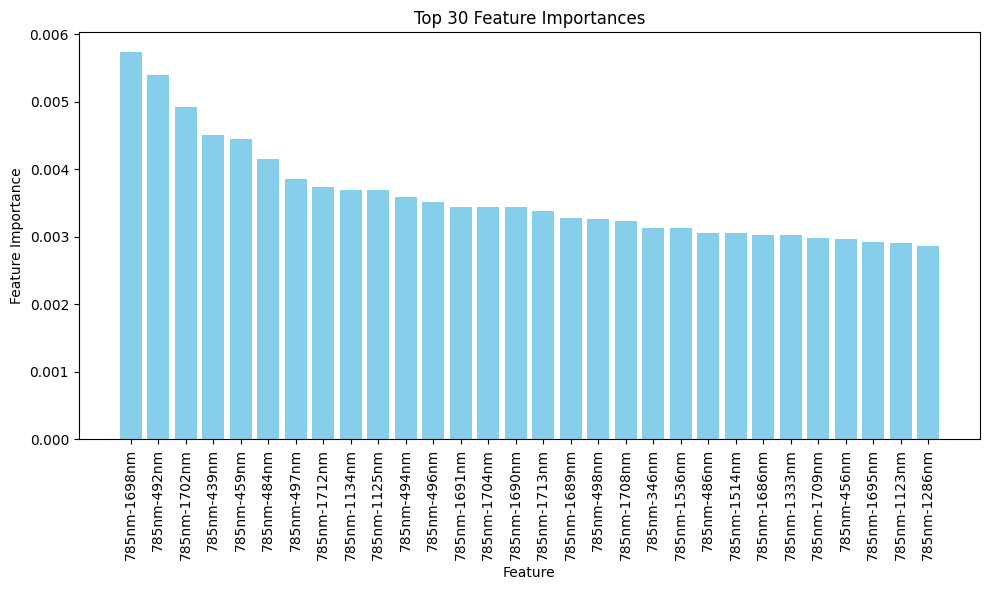

In [196]:
components = ['532nm', '638nm', '785nm']

for i, component in enumerate(components):
    x = np.concatenate((combine_waves(normed_X_train_T1, [i]), combine_waves(normed_X_train_T2, [i]), combine_waves(normed_X_train_T3, [i])), axis = 0)
    x_test = np.concatenate((combine_waves(normed_X_test_T1, [i]), combine_waves(normed_X_test_T2, [i]), combine_waves(normed_X_test_T3, [i])), axis = 0)
    y = Y_train_shaped
    y_test = Y_test_shaped
    clf, _, _, y_pred, y_val = train_and_predict(x, y, x_test, y_test, 300, 5,'log2', 'balanced', 0.7)
    draw_confusion_matrix('RF', y_test,  y_pred, component)
    draw_feature_importance(clf, 'RF', component, [component])

### per20-average two-component

Train set accuracy: 0.93
(180,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test set accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.78      0.76        60
         1.0       0.68      0.79      0.73        75
         2.0       1.00      0.67      0.80        45

    accuracy                           0.76       180
   macro avg       0.81      0.75      0.76       180
weighted avg       0.78      0.76      0.76  

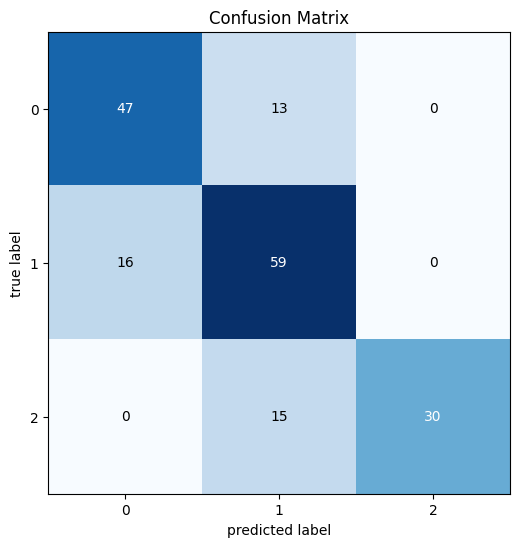

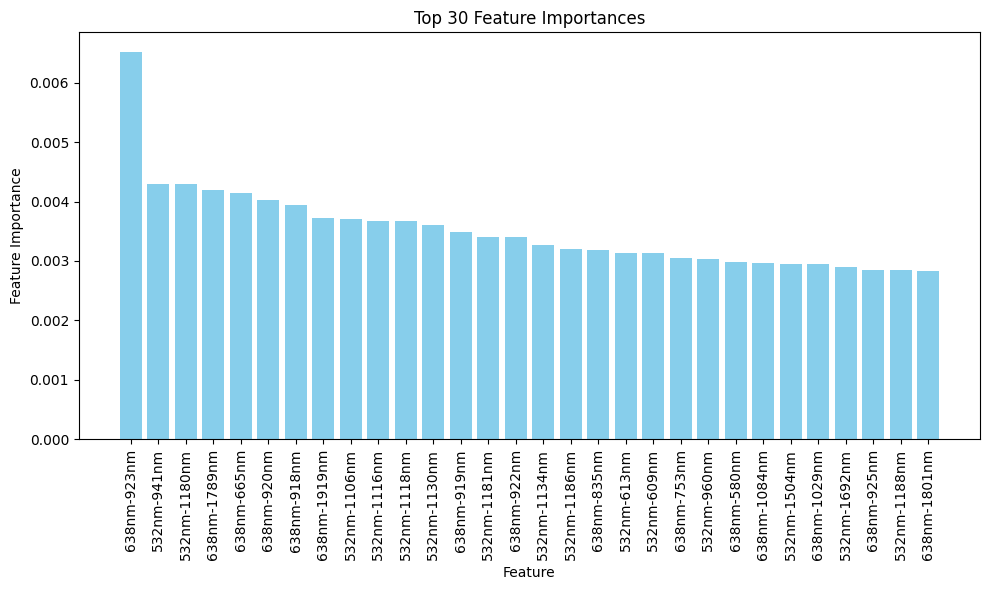

In [197]:
x = np.concatenate((combine_waves(normed_X_train_T1, [0, 1]), combine_waves(normed_X_train_T2, [0, 1]), combine_waves(normed_X_train_T3, [0, 1])), axis = 0)
x_test = np.concatenate((combine_waves(normed_X_test_T1, [0, 1]), combine_waves(normed_X_test_T2, [0, 1]), combine_waves(normed_X_test_T3, [0, 1])), axis = 0)
y = Y_train_shaped
y_test = Y_test_shaped

clf, y_train, y_train_val, y_pred, y_val = train_and_predict(x, y, x_test, y_test, 300, 3, 'log2', 'balanced', 0.9)
draw_confusion_matrix('RF', y_test,  y_pred, '532nm+638nm')
draw_feature_importance(clf, 'RF', '532nm+638nm', ['532nm', '638nm'])

Train set accuracy: 0.90
(180,)
[1. 1. 1. 1. 0. 1. 1. 2. 1. 1. 2. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 1. 1. 1.
 1. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
Test set accuracy: 0.59
Classification Report:
               precision    recall  f1-score   support

         0.0       0.35      0.27      0.30        60
         1.0       0.64      0.80      0.71        75
         2.0       0.75      0.67      0.71        45

    accuracy                           0.59       180
   macro avg       0.58      0.58      0.57       180
weighted avg       0.57      0.59      0.57  

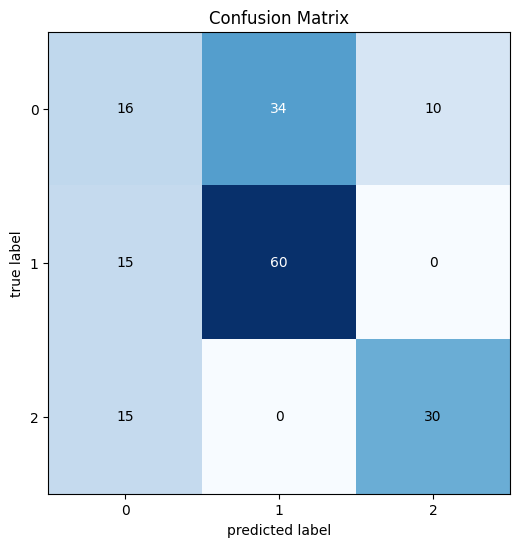

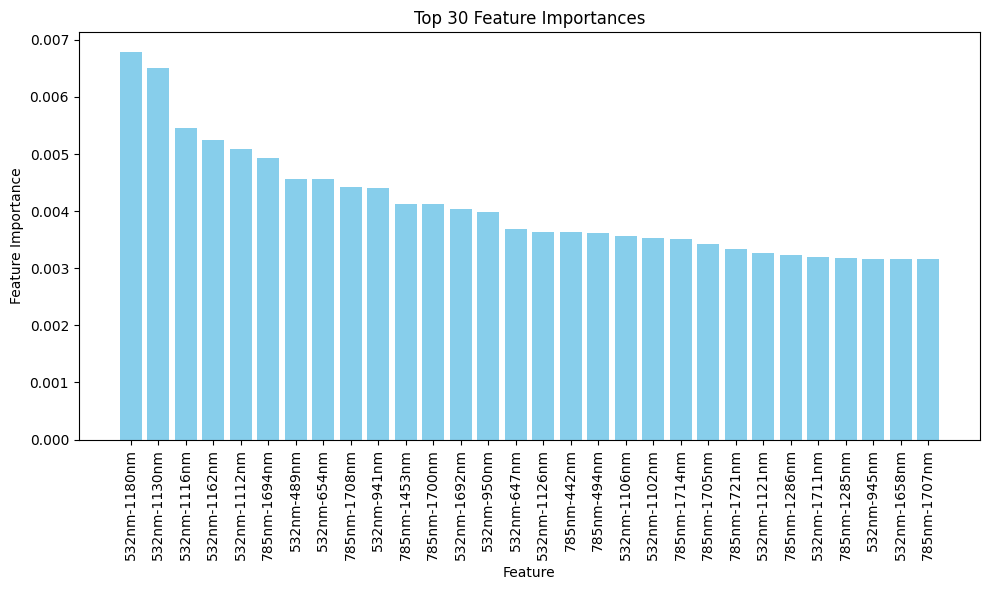

In [208]:
x = np.concatenate((combine_waves(normed_X_train_T1, [0, 2]), combine_waves(normed_X_train_T2, [0, 2]), combine_waves(normed_X_train_T3, [0, 2])), axis = 0)
x_test = np.concatenate((combine_waves(normed_X_test_T1, [0, 2]), combine_waves(normed_X_test_T2, [0, 2]), combine_waves(normed_X_test_T3, [0, 2])), axis = 0)
y = Y_train_shaped
y_test = Y_test_shaped

clf, y_train, y_train_val, y_pred, y_val = train_and_predict(x, y, x_test, y_test, 200, 3, 'log2', 'balanced', 0.9)
draw_confusion_matrix('RF', y_test,  y_pred, '532nm+785nm')
draw_feature_importance(clf, 'RF', '532nm+785nm', ['532nm', '785nm'])

Train set accuracy: 0.97
(180,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test set accuracy: 0.60
Classification Report:
               precision    recall  f1-score   support

         0.0       0.52      0.90      0.66        60
         1.0       0.63      0.52      0.57        75
         2.0       1.00      0.33      0.50        45

    accuracy                           0.60       180
   macro avg       0.72      0.58      0.58       180
weighted avg       0.69      0.60      0.58  

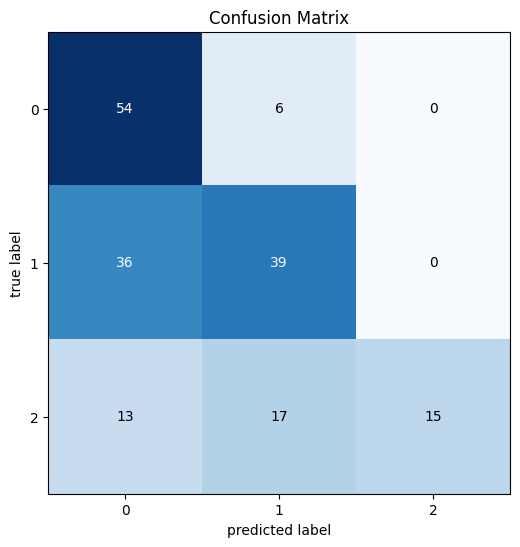

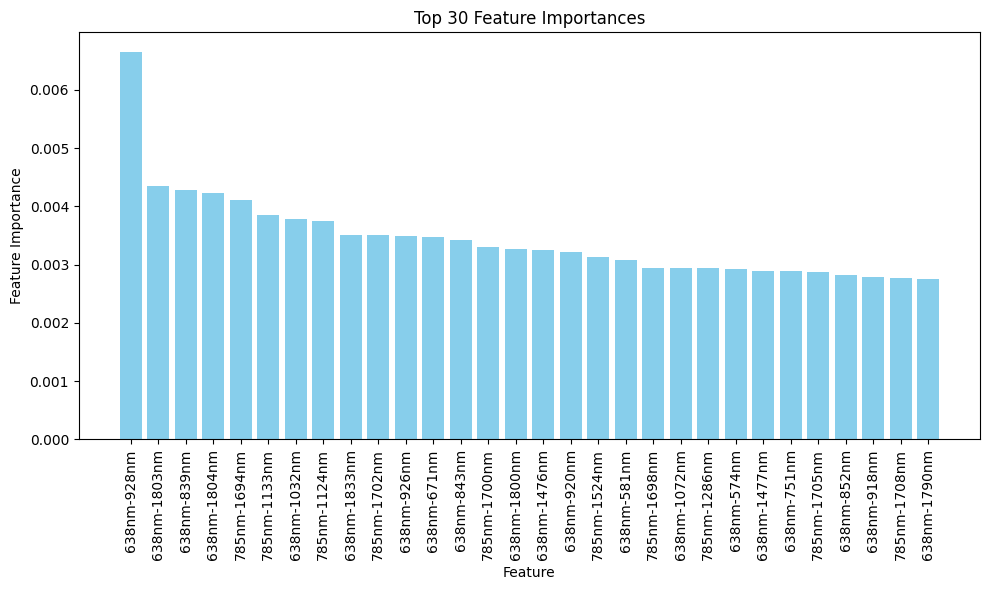

In [199]:
x = np.concatenate((combine_waves(normed_X_train_T1, [1, 2]), combine_waves(normed_X_train_T2, [1, 2]), combine_waves(normed_X_train_T3, [1, 2])), axis = 0)
x_test = np.concatenate((combine_waves(normed_X_test_T1, [1, 2]), combine_waves(normed_X_test_T2, [1, 2]), combine_waves(normed_X_test_T3, [1, 2])), axis = 0)
y = Y_train_shaped
y_test = Y_test_shaped

clf, y_train, y_train_val, y_pred, y_val = train_and_predict(x, y, x_test, y_test, 300, 3, 'log2', 'balanced', 0.9)
draw_confusion_matrix('RF', y_test,  y_pred, '638nm+785nm')
draw_feature_importance(clf, 'RF', '638nm+785nm', ['638nm', '785nm'])

In [ ]:
x = np.concatenate((combine_waves(moved_normed_X_train_T1, [1, 2]), combine_waves(moved_normed_X_train_T2, [1, 2]), combine_waves(moved_normed_X_train_T3, [1, 2])), axis = 0)
x_test = np.concatenate((combine_waves(moved_normed_X_test_T1, [1, 2]), combine_waves(moved_normed_X_test_T2, [1, 2]), combine_waves(moved_normed_X_test_T3, [1, 2])), axis = 0)
y = Y_train_shaped
y_test = Y_test_shaped
# x, x_test = standardization(x, x_test)
# x, x_test = simple_features_selection(x, x_test 

## others models

In [143]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel

def general_train_and_predict(train_set_x, train_set_y, test_set_x, test_set_y, clf, normalize=False):
    if normalize:
        scaler = StandardScaler()
        train_set_x = scaler.fit_transform(train_set_x)
        test_set_x = scaler.transform(test_set_x)

    # Train the classifier on the training set
    clf.fit(train_set_x, train_set_y)

    # Make predictions on the train set 
    y_pred_train = clf.predict(train_set_x)
    print(f"Train set accuracy: {accuracy_score(train_set_y, y_pred_train):.2f}")

    # Make predictions on the test set
    y_pred = clf.predict(test_set_x)

    print(y_pred.shape)
    print(y_pred)

    # Evaluate the performance of the classifier
    accuracy = accuracy_score(test_set_y, y_pred)
    classification_report_result = classification_report(test_set_y, y_pred)

    # Print the results
    print(f"Test set accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report_result)
    return clf, y_pred_train ,y_pred

#### knn

##### one-component knn

Train set accuracy: 0.99
(180,)
[0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0.
 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2.
 2. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.
 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 2. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 2. 2. 2. 2. 1.
 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2.]
Test set accuracy: 0.53
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.40      0.57        60
         1.0       0.63      0.75      0.68        75
         2.0       0.24      0.36      0.29        45

    accuracy                           0.53       180
   macro avg       0.62      0.50      0.51       180
weighted avg       0.66      0.53      0.55  

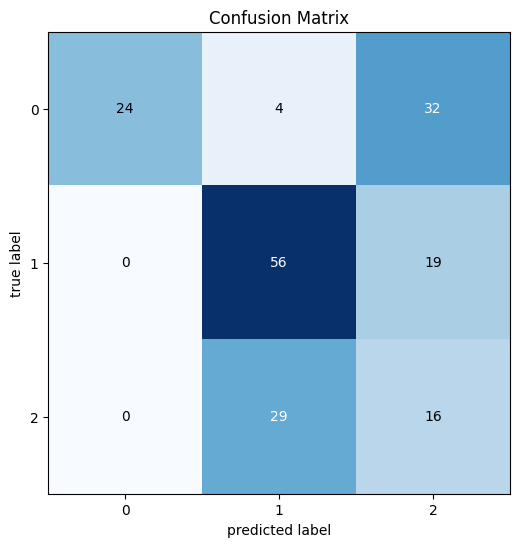

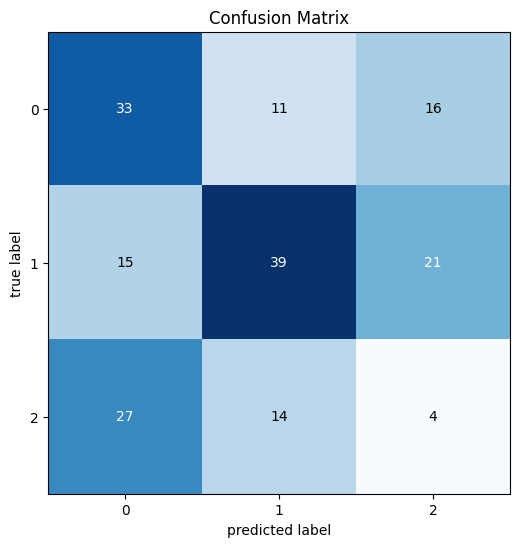

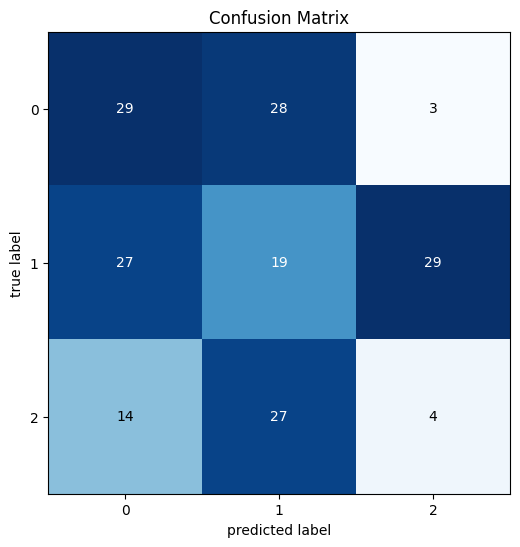

In [146]:
from sklearn.neighbors import KNeighborsClassifier


components = ['532nm', '638nm', '785nm']

for i, component in enumerate(components):
    x = np.concatenate((combine_waves(normed_X_train_T1, [i]), combine_waves(normed_X_train_T2, [i]), combine_waves(normed_X_train_T3, [i])), axis = 0)
    x_test = np.concatenate((combine_waves(normed_X_test_T1, [i]), combine_waves(normed_X_test_T2, [i]), combine_waves(normed_X_test_T3, [i])), axis = 0)
    y = Y_train_shaped
    y_test = Y_test_shaped

    knn = KNeighborsClassifier(n_neighbors=5)
    clf, _, y_pred = general_train_and_predict(x, y, x_test, y_test, knn)
    draw_confusion_matrix('KNN', y_test,  y_pred, component)

##### three-component knn

Train set accuracy: 1.00
(180,)
[0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 2. 0. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 2. 2. 1. 2. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1.
 2. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test set accuracy: 0.31
Classification Report:
               precision    recall  f1-score   support

         0.0       0.45      0.58      0.51        60
         1.0       0.27      0.24      0.26        75
         2.0       0.06      0.04      0.05        45

    accuracy                           0.31       180
   macro avg       0.26      0.29      0.27       180
weighted avg       0.28      0.31      0.29  

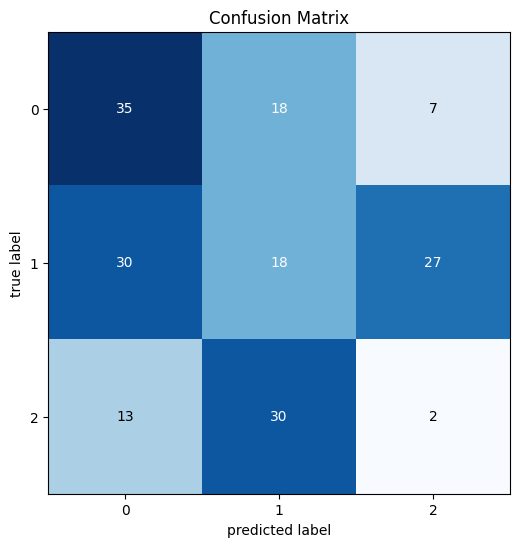

In [147]:
x = np.concatenate((combine_waves(normed_X_train_T1), combine_waves(normed_X_train_T2), combine_waves(normed_X_train_T3)), axis = 0)
x_test = np.concatenate((combine_waves(normed_X_test_T1), combine_waves(normed_X_test_T2), combine_waves(normed_X_test_T3)), axis = 0)
y = Y_train_shaped
y_test = Y_test_shaped

knn = KNeighborsClassifier(n_neighbors=5)
clf, y_train, y_pred = general_train_and_predict(x, y, x_test, y_test, knn)
draw_confusion_matrix('KNN', y_test,  y_pred, 'all')

#### LDA

##### one-component LDA

Train set accuracy: 1.00
(180,)
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 1. 0. 2. 1.
 2. 1. 1. 2. 1. 2. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0.
 0. 2. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0.
 2. 2. 2. 2. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 2. 2. 1. 1. 2. 2. 2. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 2. 1. 1. 0. 1.
 1. 0. 1. 1. 2. 2. 2. 2. 2. 0. 2. 2. 0. 2. 2. 2. 2. 2. 2. 2. 2. 0. 1. 0.
 2. 0. 0. 1. 0. 0. 0. 2. 0. 2. 1. 0.]
Test set accuracy: 0.38
Classification Report:
               precision    recall  f1-score   support

         0.0       0.29      0.33      0.31        60
         1.0       0.53      0.40      0.45        75
         2.0       0.35      0.42      0.38        45

    accuracy                           0.38       180
   macro avg       0.39      0.39      0.38       180
weighted avg       0.40      0.38      0.39  

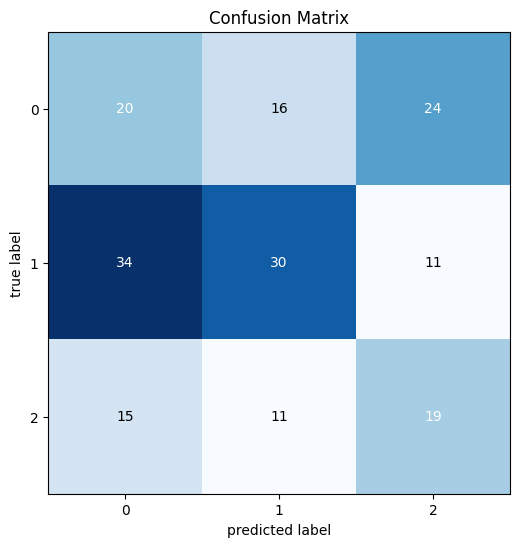

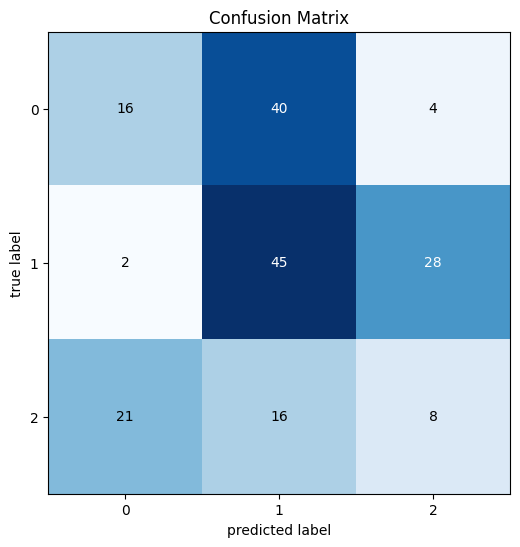

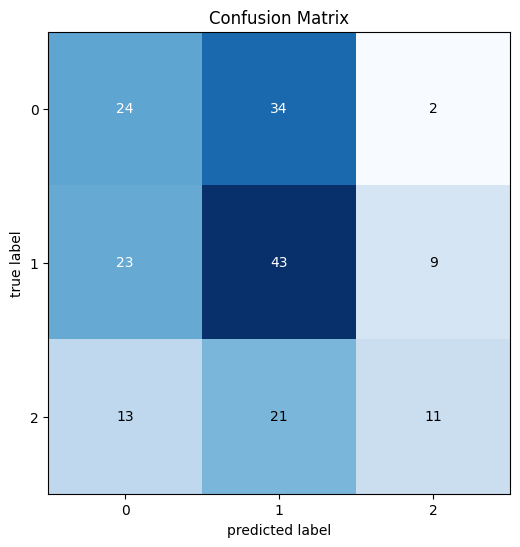

In [149]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


components = ['532nm', '638nm', '785nm']

for i, component in enumerate(components):
    x = np.concatenate((combine_waves(normed_X_train_T1, [i]), combine_waves(normed_X_train_T2, [i]), combine_waves(normed_X_train_T3, [i])), axis = 0)
    x_test = np.concatenate((combine_waves(normed_X_test_T1, [i]), combine_waves(normed_X_test_T2, [i]), combine_waves(normed_X_test_T3, [i])), axis = 0)
    y = Y_train_shaped
    y_test = Y_test_shaped
    
    lda = LinearDiscriminantAnalysis()
    clf, y_train, y_pred = general_train_and_predict(x, y, x_test, y_test, lda)
    draw_confusion_matrix('LDA', y_test,  y_pred, component)

##### three-component lda

Train set accuracy: 1.00
(180,)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 2. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 2. 2. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 1. 2. 0. 0. 2. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test set accuracy: 0.44
Classification Report:
               precision    recall  f1-score   support

         0.0       0.38      0.32      0.35        60
         1.0       0.44      0.72      0.55        75
         2.0       0.75      0.13      0.23        45

    accuracy                           0.44       180
   macro avg       0.52      0.39      0.37       180
weighted avg       0.50      0.44      0.40  

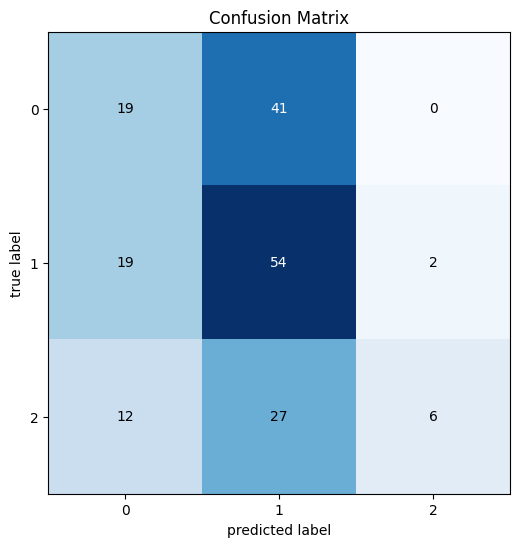

In [151]:
x = np.concatenate((combine_waves(normed_X_train_T1), combine_waves(normed_X_train_T2), combine_waves(normed_X_train_T3)), axis = 0)
x_test = np.concatenate((combine_waves(normed_X_test_T1), combine_waves(normed_X_test_T2), combine_waves(normed_X_test_T3)), axis = 0)
y = Y_train_shaped
y_test = Y_test_shaped

lda = LinearDiscriminantAnalysis()
clf, y_train, y_pred = general_train_and_predict(x, y, x_test, y_test, lda)
draw_confusion_matrix('LDA', y_test,  y_pred, 'all')

#### SVM

##### one-component SVM

Train set accuracy: 0.69
(180,)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 2. 2. 2. 2. 2. 2.
 1. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test set accuracy: 0.56
Classification Report:
               precision    recall  f1-score   support

         0.0       0.48      0.25      0.33        60
         1.0       0.54      0.99      0.70        75
         2.0       1.00      0.27      0.42        45

    accuracy                           0.56       180
   macro avg       0.67      0.50      0.48       180
weighted avg       0.64      0.56      0.51  

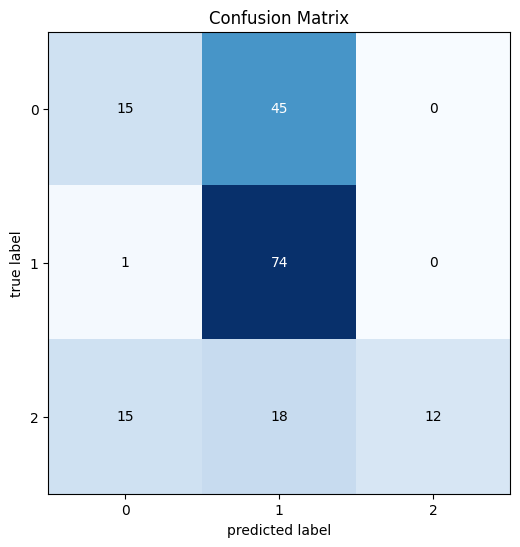

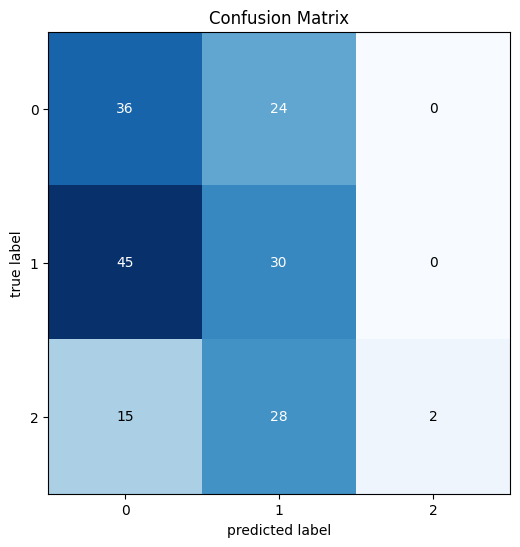

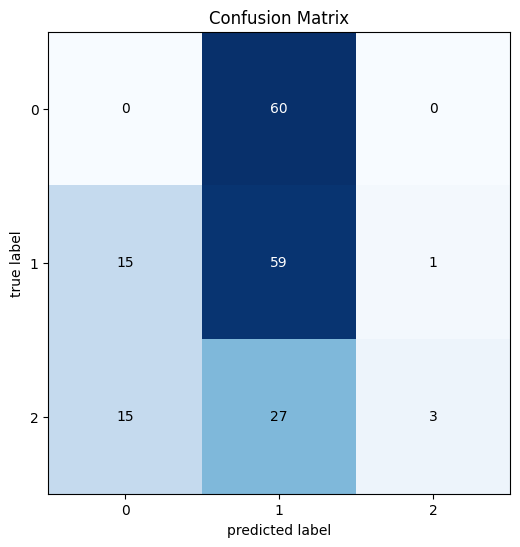

In [152]:
from sklearn.svm import SVC


components = ['532nm', '638nm', '785nm']

for i, component in enumerate(components):
    x = np.concatenate((combine_waves(normed_X_train_T1, [i]), combine_waves(normed_X_train_T2, [i]), combine_waves(normed_X_train_T3, [i])), axis = 0)
    x_test = np.concatenate((combine_waves(normed_X_test_T1, [i]), combine_waves(normed_X_test_T2, [i]), combine_waves(normed_X_test_T3, [i])), axis = 0)
    y = Y_train_shaped
    y_test = Y_test_shaped
    
    svm = SVC(kernel='linear', C=1e-4)
    clf, y_train, y_pred = general_train_and_predict(x, y, x_test, y_test, svm, True)
    draw_confusion_matrix('SVM', y_test,  y_pred, component)

##### three-component SVM

Train set accuracy: 0.66
(180,)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 2. 2. 1. 1. 1.
 1. 2. 2. 2. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test set accuracy: 0.49
Classification Report:
               precision    recall  f1-score   support

         0.0       0.38      0.25      0.30        60
         1.0       0.49      0.88      0.63        75
         2.0       1.00      0.16      0.27        45

    accuracy                           0.49       180
   macro avg       0.63      0.43      0.40       180
weighted avg       0.58      0.49      0.43  

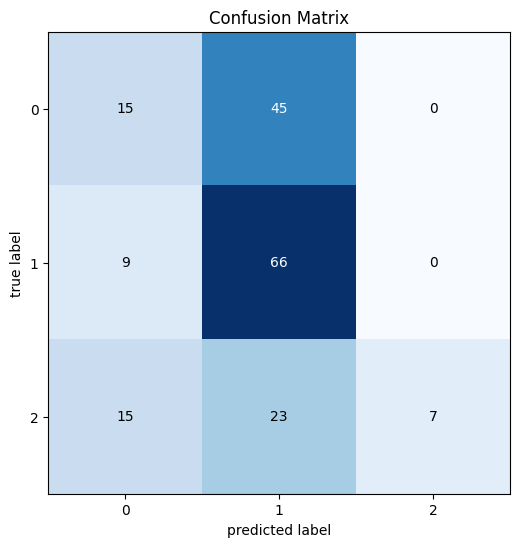

In [153]:
x = np.concatenate((combine_waves(normed_X_train_T1), combine_waves(normed_X_train_T2), combine_waves(normed_X_train_T3)), axis = 0)
x_test = np.concatenate((combine_waves(normed_X_test_T1), combine_waves(normed_X_test_T2), combine_waves(normed_X_test_T3)), axis = 0)
y = Y_train_shaped
y_test = Y_test_shaped

svm = SVC(kernel='linear', C=1e-5)
clf, y_train, y_pred = general_train_and_predict(x, y, x_test, y_test, svm, True)
draw_confusion_matrix('SVM', y_test,  y_pred, 'all')

# SMOTE LightGBM Mean

In [ ]:
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

x = np.concatenate((meaned_X_train[:,0,:] , meaned_X_train[:,1,:], meaned_X_train[:,2,:]), axis=1)
x_test = np.concatenate((meaned_X_test[:,0,:] , meaned_X_test[:,1,:], meaned_X_test[:,2,:]), axis=1)
y = Y_train
y_test = Y_test

smote = SMOTE(random_state=42)
x, y = smote.fit_resample(x, y)

# 模型训练
gbm = LGBMClassifier(num_leaves=7, learning_rate=1e-4, n_estimators=200, max_depth=3, \
                     class_weight="balanced", feature_fraction=0.05, bagging_fraction=0.7, bagging_freq=3, \
                    )
gbm.fit(x, y, eval_set=[(x_test, y_test)])

[LightGBM] [Warning] feature_fraction is set=0.05, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.05, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107163
[LightGBM] [Info] Number of data points in the train set: 60, number of used features: 5103
[LightGB

LGBMClassifier(bagging_fraction=0.7, bagging_freq=3, class_weight='balanced',
               feature_fraction=0.05, learning_rate=0.0001, max_depth=3,
               n_estimators=200, num_leaves=7)

In [ ]:
x.shape

(46, 5103)

In [ ]:
y_pred = gbm.predict(x, num_iteration=gbm.best_iteration_)
accuracy = accuracy_score(y, y_pred)
classification_report_result = classification_report(y, y_pred)
# Print the results
print(f"Train set accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report_result)

[LightGBM] [Warning] feature_fraction is set=0.05, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Train set accuracy: 0.82
Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.90      0.82        20
         1.0       0.94      0.75      0.83        20
         2.0       0.80      0.80      0.80        20

    accuracy                           0.82        60
   macro avg       0.83      0.82      0.82        60
weighted avg       0.83      0.82      0.82        60



In [ ]:
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration_)
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)
# Print the results
print(f"Test set accuracy: {accuracy:.3f}")
print("Classification Report:\n", classification_report_result)

[LightGBM] [Warning] feature_fraction is set=0.05, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Test set accuracy: 0.667
Classification Report:
               precision    recall  f1-score   support

         0.0       0.50      0.75      0.60         4
         1.0       0.75      0.60      0.67         5
         2.0       1.00      0.67      0.80         3

    accuracy                           0.67        12
   macro avg       0.75      0.67      0.69        12
weighted avg       0.73      0.67      0.68        12



# LightGBM

In [154]:
from lightgbm import LGBMClassifier

In [171]:
# x = np.concatenate((combine_waves(moved_normed_X_train_T1), combine_waves(moved_normed_X_train_T2), combine_waves(moved_normed_X_train_T3)), axis = 0)
# x_test = np.concatenate((combine_waves(moved_normed_X_test_T1), combine_waves(moved_normed_X_test_T2), combine_waves(moved_normed_X_test_T3)), axis = 0)
# y = Y_train_shaped
# y_test = Y_test_shaped

x = np.concatenate((combine_waves(normed_X_train_T1), combine_waves(normed_X_train_T2), combine_waves(normed_X_train_T3)), axis = 0)
x_test = np.concatenate((combine_waves(normed_X_test_T1), combine_waves(normed_X_test_T2), combine_waves(normed_X_test_T3)), axis = 0)
y = Y_train_shaped
y_test = Y_test_shaped


# 模型训练
gbm = LGBMClassifier(num_leaves=7, learning_rate=1e-4, n_estimators=200, max_depth=3, \
                     class_weight="balanced", feature_fraction=0.025, bagging_fraction=0.7, bagging_freq=3, \
                     early_stopping_round=100, reg_alpha=10, reg_lambda=10)
gbm.fit(x, y, eval_set=[(x_test, y_test)])

[LightGBM] [Warning] feature_fraction is set=0.025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.025
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.025
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178793
[LightGBM] [Info] Number of data points in the train set: 690, number of used features: 5103
[L

LGBMClassifier(bagging_fraction=0.7, bagging_freq=3, class_weight='balanced',
               early_stopping_round=100, feature_fraction=0.025,
               learning_rate=0.0001, max_depth=3, n_estimators=200,
               num_leaves=7, reg_alpha=10, reg_lambda=10)

In [ ]:
y_pred = gbm.predict(x, num_iteration=gbm.best_iteration_)
accuracy = accuracy_score(y, y_pred)
classification_report_result = classification_report(y, y_pred)
# Print the results
print(f"Train set accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report_result)

[LightGBM] [Warning] feature_fraction is set=0.022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.022
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Train set accuracy: 0.94
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       210
         1.0       1.00      0.88      0.94       300
         2.0       0.89      0.98      0.93       180

    accuracy                           0.94       690
   macro avg       0.94      0.95      0.94       690
weighted avg       0.95      0.94      0.94       690



In [172]:
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration_)
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)
# Print the results
print(f"Test set accuracy: {accuracy:.3f}")
print("Classification Report:\n", classification_report_result)

[LightGBM] [Warning] feature_fraction is set=0.025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.025
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Test set accuracy: 0.833
Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.83      0.78        60
         1.0       0.84      0.79      0.81        75
         2.0       1.00      0.91      0.95        45

    accuracy                           0.83       180
   macro avg       0.86      0.84      0.85       180
weighted avg       0.84      0.83      0.84       180



In [175]:
from lightgbm import LGBMClassifier
def lgb_train_test(x, y, x_test, y_test, feature_fraction=0.06, bagging_fraction=0.7, bagging_freq=3):
    # Assuming X is your feature matrix and y is your target variable
    # clf = LGBMClassifier(num_leaves=7, learning_rate=1e-4, n_estimators=200, max_depth=3, \
    #                  class_weight="balanced", feature_fraction=0.025, bagging_fraction=0.7, bagging_freq=3, \
    #                  early_stopping_round=100, reg_alpha=110, reg_lambda=800, verbosity=-1)
    
    # clf = LGBMClassifier(num_leaves=7, learning_rate=1e-4, n_estimators=200, max_depth=3, \
    #                  class_weight="balanced", feature_fraction=feature_fraction, bagging_fraction=bagging_fraction, bagging_freq=bagging_freq, \
    #                  early_stopping_round=100, reg_alpha=10, reg_lambda=10, verbosity=-1)

    clf = LGBMClassifier(num_leaves=7, learning_rate=1e-4, n_estimators=200, max_depth=3, \
                     class_weight="balanced", feature_fraction=0.025, bagging_fraction=0.7, bagging_freq=3, \
                     early_stopping_round=100, reg_alpha=10, reg_lambda=10, verbosity=-1)

    # Train the classifier on the training set
    clf.fit(x, y, eval_set=[(x, y)])

    # Make predictions on the train set 
    y_pred_train = clf.predict(x)
    print(f"Train set accuracy: {accuracy_score(y, y_pred_train):.2f}")

    # Make predictions on the test set
    y_pred = clf.predict(x_test)

    print(y_pred.shape)
    print(y_pred)

    # Evaluate the performance of the classifier
    accuracy = accuracy_score(y_test, y_pred)
    classification_report_result = classification_report(y_test, y_pred)

    # Print the results
    print(f"Test set accuracy: {accuracy:.3f}")
    print("Classification Report:\n", classification_report_result)
    return clf, y_pred_train, clf.predict_proba(x) ,y_pred, clf.predict_proba(x_test)


## one-component lightgbm

c:\Users\Hang Li\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\callback.py:294: UserWarning: Only training set found, disabling early stopping.
  _log_warning('Only training set found, disabling early stopping.')


Train set accuracy: 0.91
(180,)
[1. 1. 1. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 1. 1. 2. 1. 1. 2. 2. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 2. 0. 2. 0. 0. 2. 0. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
Test set accuracy: 0.567
Classification Report:
               precision    recall  f1-score   support

         0.0       0.28      0.18      0.22        60
         1.0       0.66      0.80      0.72        75
         2.0       0.63      0.69      0.66        45

    accuracy                           0.57       180
   macro avg       0.52      0.56      0.53       180
weighted avg       0.52      0.57      0.54 

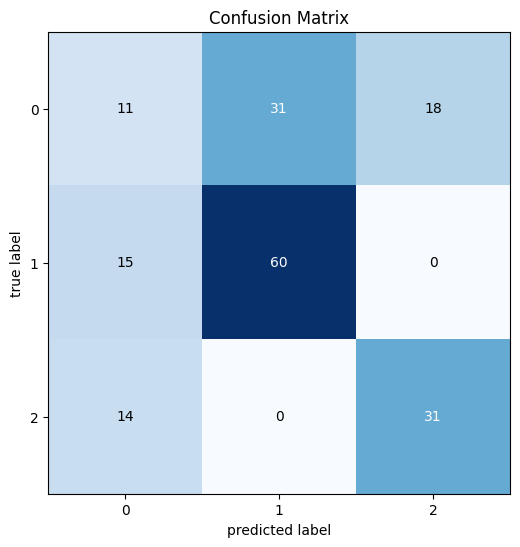

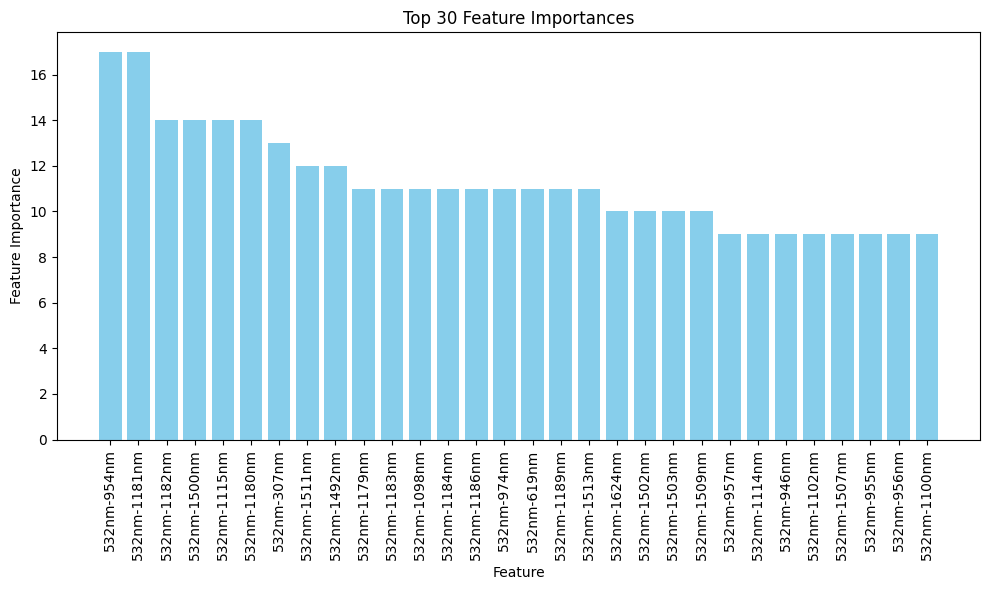

c:\Users\Hang Li\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\callback.py:294: UserWarning: Only training set found, disabling early stopping.
  _log_warning('Only training set found, disabling early stopping.')


Train set accuracy: 0.95
(180,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test set accuracy: 0.572
Classification Report:
               precision    recall  f1-score   support

         0.0       0.53      0.97      0.68        60
         1.0       0.63      0.41      0.50        75
         2.0       0.67      0.31      0.42        45

    accuracy                           0.57       180
   macro avg       0.61      0.56      0.54       180
weighted avg       0.61      0.57      0.54 

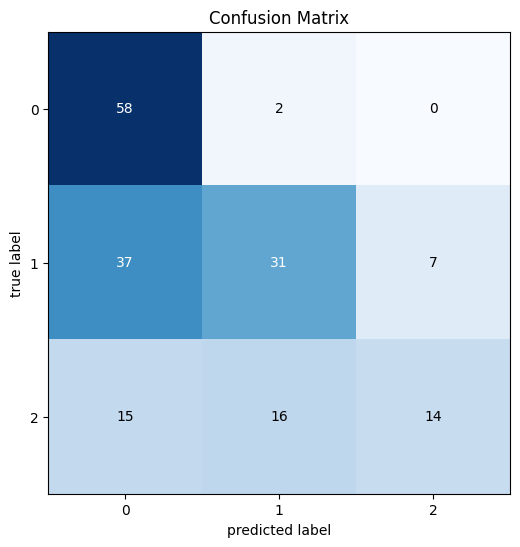

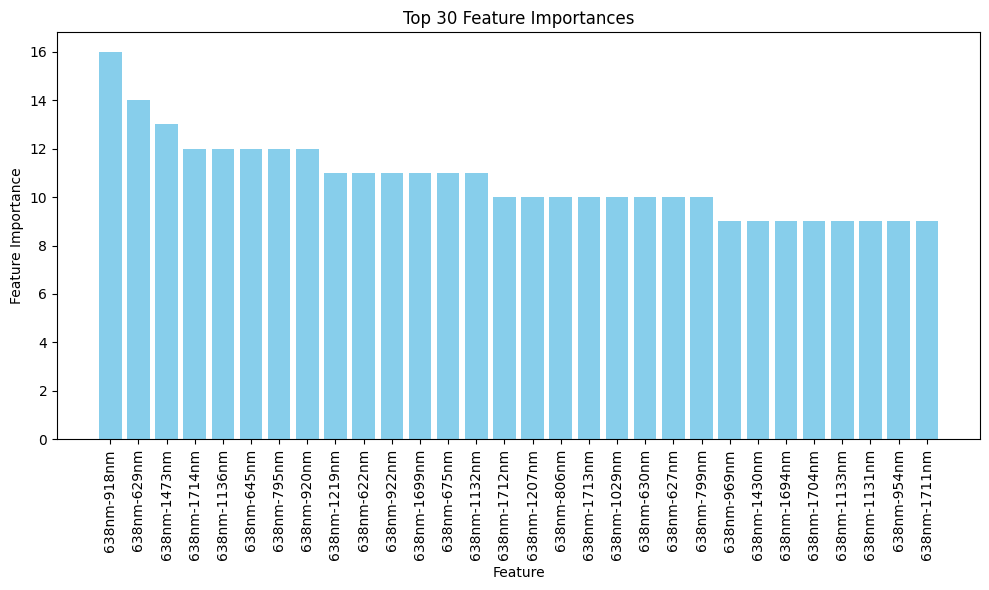

c:\Users\Hang Li\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\callback.py:294: UserWarning: Only training set found, disabling early stopping.
  _log_warning('Only training set found, disabling early stopping.')


Train set accuracy: 0.89
(180,)
[0. 0. 0. 2. 0. 0. 0. 2. 0. 0. 2. 1. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 1. 2. 2. 1. 1. 1. 2. 1. 1.
 2. 1. 1. 2. 1. 2. 2. 2. 2. 1. 1. 1. 1. 2. 1. 2. 2. 2. 0. 2. 0. 2. 2. 1.
 2. 2. 0. 0. 0. 2. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test set accuracy: 0.406
Classification Report:
               precision    recall  f1-score   support

         0.0       0.54      0.43      0.48        60
         1.0       0.50      0.60      0.55        75
         2.0       0.05      0.04      0.05        45

    accuracy                           0.41       180
   macro avg       0.36      0.36      0.36       180
weighted avg       0.40      0.41      0.40 

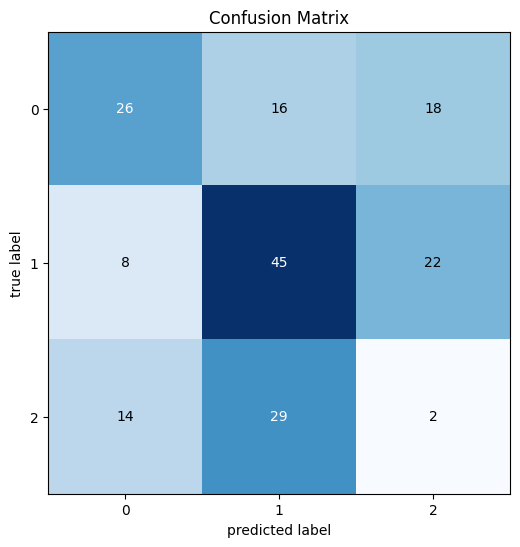

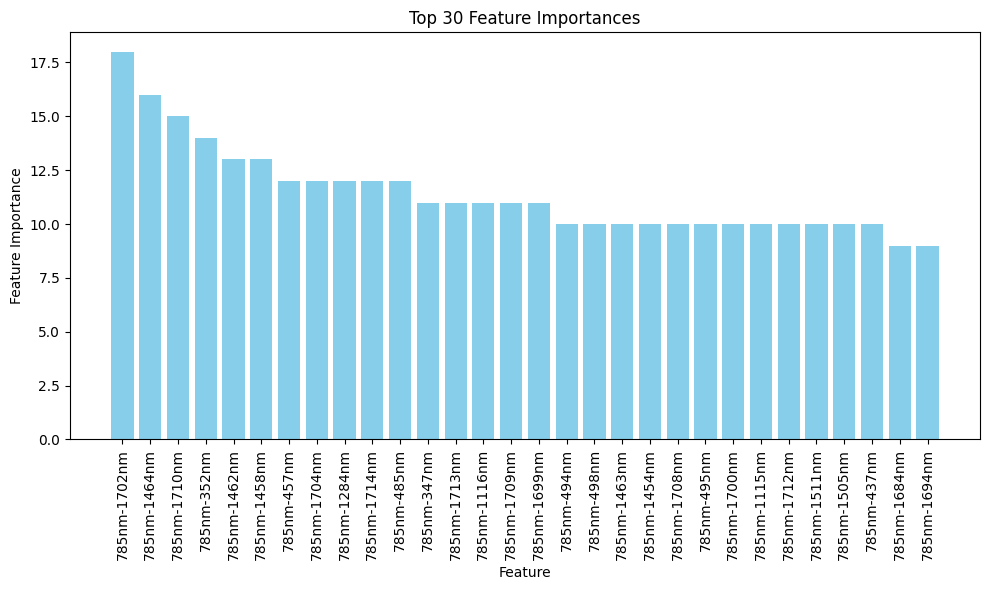

In [200]:
components = ['532nm', '638nm', '785nm']

for i, component in enumerate(components):
    x = np.concatenate((combine_waves(normed_X_train_T1, [i]), combine_waves(normed_X_train_T2, [i]), combine_waves(normed_X_train_T3, [i])), axis = 0)
    x_test = np.concatenate((combine_waves(normed_X_test_T1, [i]), combine_waves(normed_X_test_T2, [i]), combine_waves(normed_X_test_T3, [i])), axis = 0)
    y = Y_train_shaped
    y_test = Y_test_shaped
    
    clf, y_train, y_train_val, y_pred, y_val = lgb_train_test(x, y, x_test, y_test)
    draw_confusion_matrix('lightgbm', y_test,  y_pred, component)
    draw_feature_importance(clf, 'lightgbm', component, [component])

## two-component lightgbm

c:\Users\Hang Li\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\callback.py:294: UserWarning: Only training set found, disabling early stopping.
  _log_warning('Only training set found, disabling early stopping.')


Train set accuracy: 0.96
(180,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 2. 2.
 2. 2. 2. 2. 2. 0. 2. 0. 2. 0. 2. 2.]
Test set accuracy: 0.833
Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.82      0.77        60
         1.0       0.85      0.80      0.82        75
         2.0       1.00      0.91      0.95        45

    accuracy                           0.83       180
   macro avg       0.86      0.84      0.85       180
weighted avg       0.84      0.83      0.84 

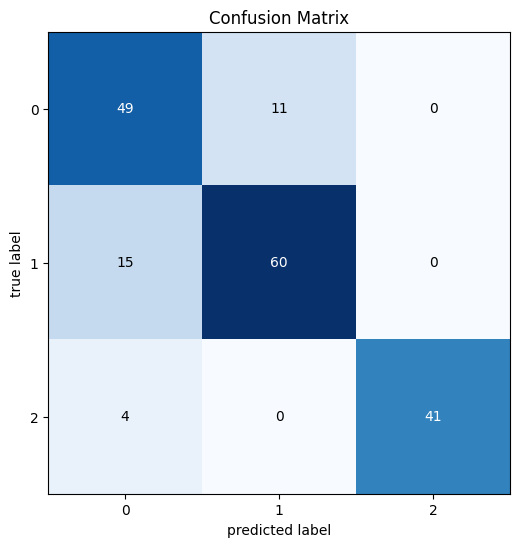

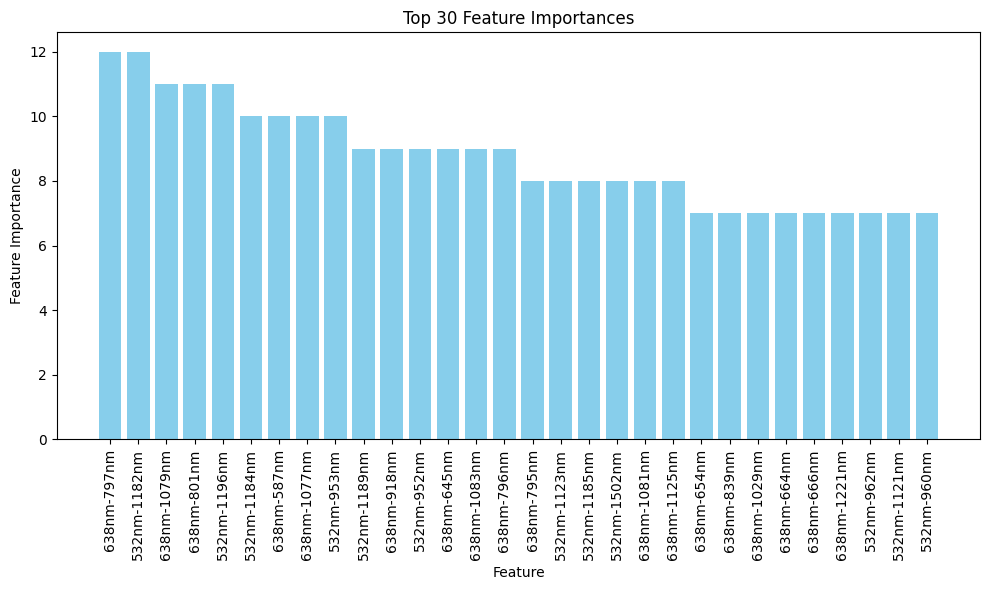

In [201]:
x = np.concatenate((combine_waves(normed_X_train_T1, [0, 1]), combine_waves(normed_X_train_T2, [0, 1]), combine_waves(normed_X_train_T3, [0, 1])), axis = 0)
x_test = np.concatenate((combine_waves(normed_X_test_T1, [0, 1]), combine_waves(normed_X_test_T2, [0, 1]), combine_waves(normed_X_test_T3, [0, 1])), axis = 0)
y = Y_train_shaped
y_test = Y_test_shaped
# x, x_test = standardization(x, x_test)
# x, x_test = simple_features_selection(x, x_test, y)
clf, y_train, y_train_val, y_pred, y_val = lgb_train_test(x, y, x_test, y_test)
draw_confusion_matrix('lightgbm', y_test,  y_pred, '532nm+638nm')
draw_feature_importance(clf, 'lightgbm', '532nm+638nm', ['532nm', '638nm'])
# draw_pr_curve(y_test, y_val[:,1], 'total', 'P1')
# draw_roc_curve(y_test, y_val[:,1], 'total', 'P1')
# draw_feature_importance(clf, 'total', 'P1')

c:\Users\Hang Li\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\callback.py:294: UserWarning: Only training set found, disabling early stopping.
  _log_warning('Only training set found, disabling early stopping.')


Train set accuracy: 0.94
(180,)
[1. 1. 1. 2. 0. 1. 1. 2. 1. 1. 2. 1. 2. 2. 1. 1. 2. 2. 2. 1. 2. 2. 1. 1.
 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
Test set accuracy: 0.594
Classification Report:
               precision    recall  f1-score   support

         0.0       0.36      0.27      0.31        60
         1.0       0.65      0.80      0.72        75
         2.0       0.70      0.69      0.70        45

    accuracy                           0.59       180
   macro avg       0.57      0.59      0.57       180
weighted avg       0.57      0.59      0.58 

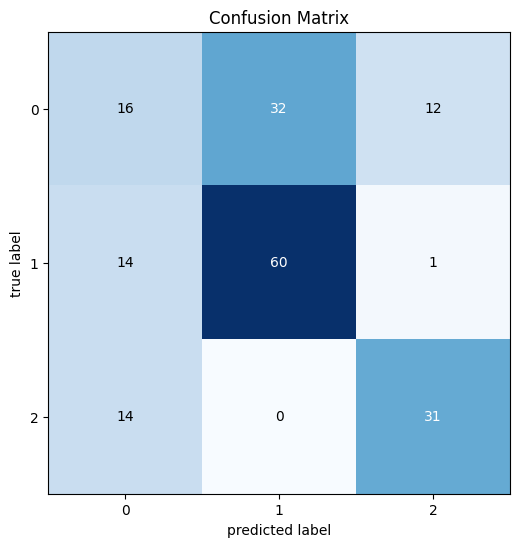

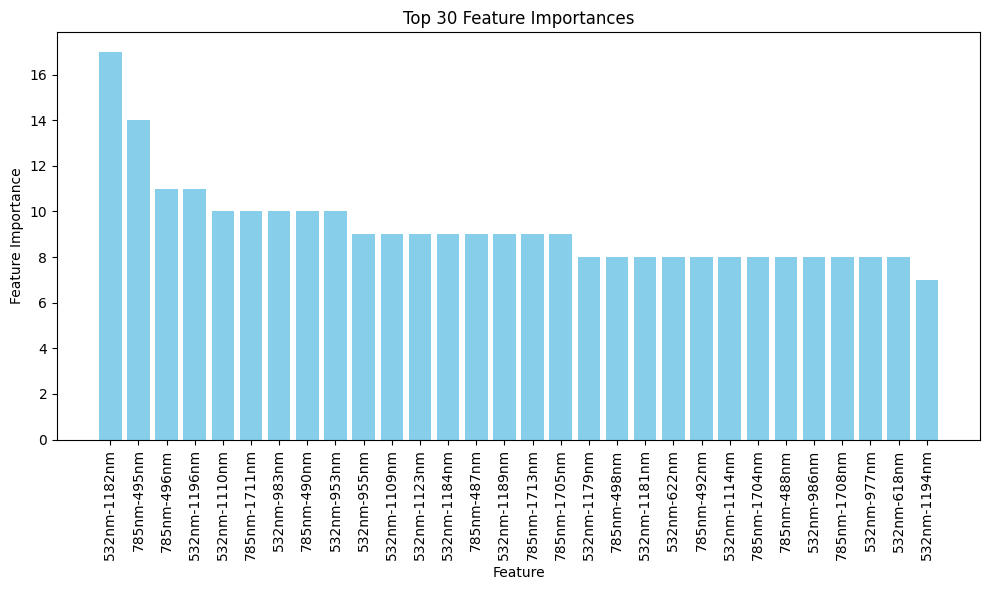

In [202]:
x = np.concatenate((combine_waves(normed_X_train_T1, [0, 2]), combine_waves(normed_X_train_T2, [0, 2]), combine_waves(normed_X_train_T3, [0, 2])), axis = 0)
x_test = np.concatenate((combine_waves(normed_X_test_T1, [0, 2]), combine_waves(normed_X_test_T2, [0, 2]), combine_waves(normed_X_test_T3, [0, 2])), axis = 0)
y = Y_train_shaped
y_test = Y_test_shaped
# x, x_test = standardization(x, x_test)
# x, x_test = simple_features_selection(x, x_test, y)
clf, y_train, y_train_val, y_pred, y_val = lgb_train_test(x, y, x_test, y_test)
draw_confusion_matrix('lightgbm', y_test,  y_pred, '532nm+785nm')
draw_feature_importance(clf, 'lightgbm', '532nm+785nm', ['532nm', '785nm'])

c:\Users\Hang Li\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\callback.py:294: UserWarning: Only training set found, disabling early stopping.
  _log_warning('Only training set found, disabling early stopping.')


Train set accuracy: 0.97
(180,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 1. 1. 2. 2. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 1. 1. 2. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 2. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test set accuracy: 0.522
Classification Report:
               precision    recall  f1-score   support

         0.0       0.56      0.80      0.66        60
         1.0       0.43      0.41      0.42        75
         2.0       0.65      0.33      0.44        45

    accuracy                           0.52       180
   macro avg       0.55      0.52      0.51       180
weighted avg       0.53      0.52      0.51 

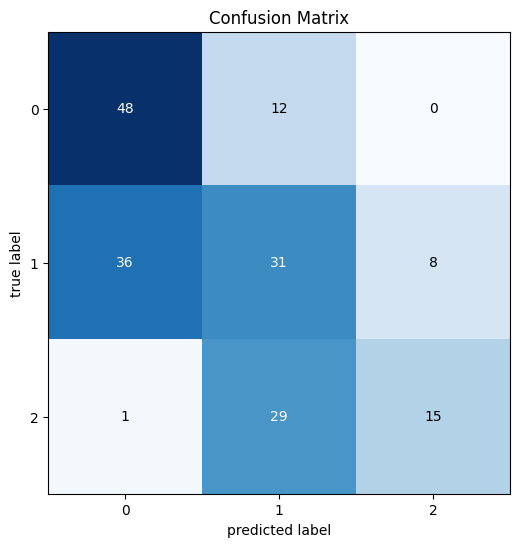

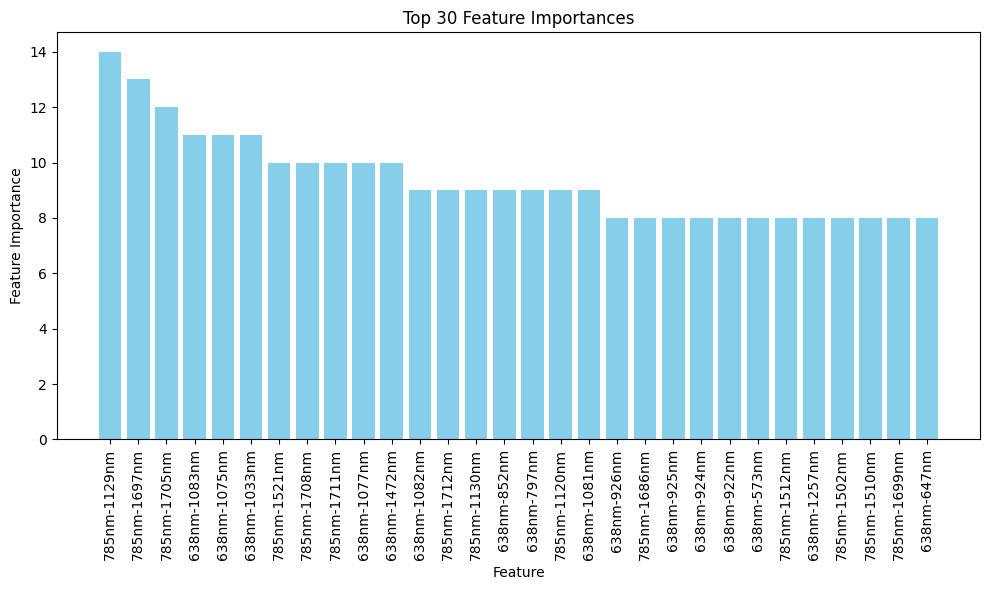

In [203]:
x = np.concatenate((combine_waves(normed_X_train_T1, [1, 2]), combine_waves(normed_X_train_T2, [1, 2]), combine_waves(normed_X_train_T3, [1, 2])), axis = 0)
x_test = np.concatenate((combine_waves(normed_X_test_T1, [1, 2]), combine_waves(normed_X_test_T2, [1, 2]), combine_waves(normed_X_test_T3, [1, 2])), axis = 0)
y = Y_train_shaped
y_test = Y_test_shaped
# x, x_test = standardization(x, x_test)
# x, x_test = simple_features_selection(x, x_test, y)
clf, y_train, y_train_val, y_pred, y_val = lgb_train_test(x, y, x_test, y_test)
draw_confusion_matrix('lightgbm', y_test,  y_pred, '638nm+785nm')
draw_feature_importance(clf, 'lightgbm', '638nm+785nm', ['638nm', '785nm'])
# draw_pr_curve(y_test, y_val[:,1], 'total', 'P1')
# draw_roc_curve(y_test, y_val[:,1], 'total', 'P1')
# draw_feature_importance(clf, 'total', 'P1')

## three-component lightgbm

c:\Users\Hang Li\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\callback.py:294: UserWarning: Only training set found, disabling early stopping.
  _log_warning('Only training set found, disabling early stopping.')


Train set accuracy: 0.98
(180,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 0. 0. 2. 0. 1. 2. 2.]
Test set accuracy: 0.833
Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.83      0.78        60
         1.0       0.84      0.79      0.81        75
         2.0       1.00      0.91      0.95        45

    accuracy                           0.83       180
   macro avg       0.86      0.84      0.85       180
weighted avg       0.84      0.83      0.84 

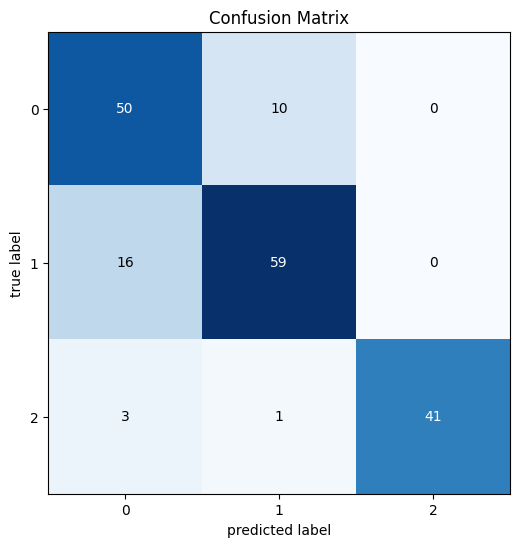

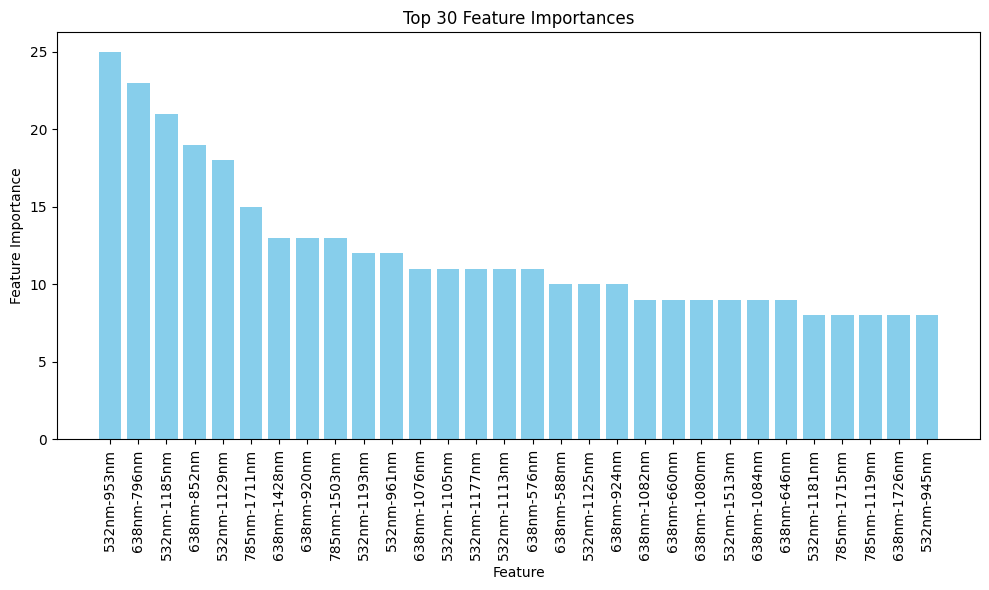

In [178]:
x = np.concatenate((combine_waves(normed_X_train_T1), combine_waves(normed_X_train_T2), combine_waves(normed_X_train_T3)), axis = 0)
x_test = np.concatenate((combine_waves(normed_X_test_T1), combine_waves(normed_X_test_T2), combine_waves(normed_X_test_T3)), axis = 0)
y = Y_train_shaped
y_test = Y_test_shaped

clf, y_train, y_train_val, y_pred, y_val = lgb_train_test(x, y, x_test, y_test)
draw_confusion_matrix('lightgbm', y_test,  y_pred, 'all')
draw_feature_importance(clf, 'lightgbm', 'all')